In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle as astropy_ls
from scipy import optimize


import matplotlib 
matplotlib.rc('xtick', labelsize=27) 
matplotlib.rc('ytick', labelsize=27) 
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)




In [2]:
def get_chisq(observed_data, predicted_data, uncertainties):
    """
    Calculate the chi-square statistic for model evaluation.

    Parameters:
        observed_data (numpy array): Array of observed data points.
        predicted_data (numpy array): Array of model-predicted data points.
        uncertainties (numpy array): Array of uncertainties/standard deviations of the observed data.

    Returns:
        float: The chi-square statistic.
    """
    if len(observed_data) != len(predicted_data) or len(observed_data) != len(uncertainties):
        raise ValueError("All input arrays must have the same length.")

    squared_residuals = ((observed_data - predicted_data) ** 2. / (uncertainties ** 2.) )
    chi_square = np.sum(squared_residuals)

    return chi_square


def get_log_likelihood(chi_square):
    """
    Calculate the log-likelihood from the chi-square value.

    Parameters:
        chi_square (float): The chi-square value of the model.
        num_data_points (int): Number of data points (sample size).

    Returns:
        float: The log-likelihood.
    """
    log_likelihood = -0.5 * chi_square
    return log_likelihood

def get_BIC(num_params, num_data_points, log_likelihood):
    """
    Calculate the Bayesian Information Criterion (BIC).

    Parameters:
        num_params (int): Number of parameters in the model.
        num_data_points (int): Number of data points (sample size).
        log_likelihood (float): Log-likelihood of the model.

    Returns:
        float: The BIC value.
    """
    BIC = num_params * np.log(num_data_points) - 2 * log_likelihood
    return BIC



def get_AIC(observed, predicted, uncertainties, num_parameters):
    """
    Calculate the Akaike Information Criterion (AIC) for a model with data uncertainties.

    Parameters:
        observed (array-like): The observed data.
        predicted (array-like): The model's predicted values.
        uncertainties (array-like): The uncertainties on the observed data.
        num_parameters (int): The number of parameters in the model.

    Returns:
        float: The AIC value.
    """
    # Calculate the number of data points
    n = len(observed)

    # Calculate the weighted sum of squared residuals (RSS)
    residuals = np.array(observed) - np.array(predicted)
    rss = np.sum((residuals / uncertainties)**2)

    # Calculate the AIC value
    aic = n * np.log(rss / n) + 2 * num_parameters

    return aic


In [3]:
def get_times_null_model(epochs, T0, P): 
    """
    Generates null model times based on linear ephemeris.

    Parameters:
    - epochs (np.array): Array of epochs.
    - T0 (float): Reference time of the first transit.
    - P (float): Orbital period.

    Returns:
    - np.array: Array of null model times.
    """
    return T0 + P*epochs


def solve_null_model(epochs, times, times_err):
    """
    Solves for T0 and P in a null model using linear regression.

    Parameters:
    - epochs (np.array): Array of epochs.
    - times (np.array): Array of observed transit times.
    - times_err (np.array): Array of errors associated with observed transit times.

    Returns:
    - Tuple: Tuple containing T0_fit (float) and P_fit (float), the fitted parameters.
    """
    
    # Constructing the design matrix A
    A = np.column_stack([
        np.ones_like(epochs),
        epochs
    ])

    # Constructing the weight matrix W using times_err
    W = np.diag(1.0 / times_err**2.)

    # Constructing the observed times vector y
    y = times

    # Calculating the parameters using np.linalg.solve
    parameters = np.linalg.solve(A.T @ W @ A, A.T @ W @ y)

    T0_fit, P_fit = parameters

    return T0_fit, P_fit

In [4]:
def get_times_n_waves(epochs, T0, P, P_LS_ttv, *fourier_params):
    """
    Calculate the time as a function of epochs with multiple waves.

    Parameters:
    - epochs: array-like, time values
    - T0: float, reference time
    - P: float, linear period
    - P_LS_ttv: float, period for the last wave
    - *fourier_params: variable number of Fourier parameters for each wave

    Returns:
    - times: array-like, calculated times
    """

    # Determine the number of waves
    n = (len(fourier_params) + 1) // 3

    # Calculate linear component
    linear = T0 + P * epochs

    # Initialize the total wave component
    waves = 0

    # Iterate through waves
    for ii in range(n - 1):
        alpha_i_ttv, beta_i_ttv, P_i_ttv = fourier_params[3 * ii: 3 * (ii + 1)]

        # Calculate wave for the current Fourier parameters
        wave_i = alpha_i_ttv * np.sin((2 * np.pi * epochs / P_i_ttv)) + beta_i_ttv * np.cos((2 * np.pi * epochs / P_i_ttv))

        # Add the current wave to the total
        waves += wave_i

    # Calculate the last wave separately
    alpha_LS_ttv, beta_LS_ttv = fourier_params[3 * (n - 1): 3 * n]
    wave_LS = alpha_LS_ttv * np.sin((2 * np.pi * epochs / P_LS_ttv)) + beta_LS_ttv * np.cos((2 * np.pi * epochs / P_LS_ttv))
    waves += wave_LS

    # Combine linear and wave components to get the final result
    times = linear + waves

    return times


In [5]:
def hill_stability_check(mu1, mu2, P1, P2, e1, e2):

	'''
	tests Petit et al. (2018) Hill criterion
	planet 1 needs to be the inner

	Inputs
	mu1, mu2: mp/mstar
	P1, P2: periods
	e1, e2: eccenticities

	Outputs
	Hill_stable: Boolean of whether the system is Hill stable

	'''

	gamma = (mu1/mu2)
	P1P2third = (P1/P2)**(1/3)
	alpha = P1P2third**(2)
	epsilon = mu1 + mu2
	e1x = np.sqrt( 1. - e1**(2) )
	e2x = np.sqrt( 1. - e2**(2) )

	# C of the system, Eq 23 of Petit et al. (2018)
	inc1 = 0. # coplanar approx
	inc2 = 0. # coplanar approx
	Csys = gamma*P1P2third*( 1. - e1x*np.cos(inc1) ) + 1. - e2x*np.cos(inc2)

	# Critical C, Eq 26 of Petit et al. (2018)
	k1 = 3**(4/3)
	Ccrit = ( k1*epsilon**(2/3)*gamma )/( 1. + gamma )**(2)
	Ccrit = (alpha/(gamma+alpha))*(1.+Ccrit)
	Ccrit = gamma*P1P2third + 1. - np.sqrt( (1.+gamma)**(3)*Ccrit )


	if Csys < Ccrit:
		Hill_stable = True
	else:
		Hill_stable = False


	return Hill_stable















def chaos_stability_check(mu1, mu2, P1, P2, e1, e2, w1, w2):

	'''
	as presented in Tamayo et al 2021, 
	https://iopscience.iop.org/article/10.3847/0004-637X/823/2/118/pdf
	but originally from Hadden and Lithwick 2018...
	https://iopscience.iop.org/article/10.3847/1538-3881/aad32c/pdf

	tests Hadden & Lithwick (2018) chaos criterion
	technically 1 is inner planet, 2 is outer planet, but we use an abs
	function around the a2-a1 functions which should remove this issue
	because cos(x) is symmetric about x too

	Inputs
	mu1, mu2: mp/mstar
	P1, P2: periods
	e1, e2: eccenticities
	w1, w2: varpi of each planet... longitude of perihelion = omega + Omega

	Outputs
	non_chaotic: Boolean of whether the system is NOT chaotic

	'''
	
	roothalf = np.sqrt(1./2.)
	third = 1./3.
	twothirds = 2./3.
	fourthirds = 4./3.
	

	# Z of the system, Eq 16 of Hadden & Lithwick (2018)
	Zsys = roothalf*np.sqrt( e1**2 + e2**2 - ( 2.*e1*e2*np.cos(w1-w2) ) )

	# Not strictly true, but OK since we only ever use a1/a2 ratios
	a1 = P1**(twothirds)
	a2 = P2**(twothirds)

	# Critical Z, Eq 19 of Hadden & Lithwick (2018)
	Zcrit = -2.2*(mu1+mu2)**third*np.absolute(a2/(a2-a1))**fourthirds
	Zcrit = roothalf*np.absolute((a2-a1)/a1)*np.exp( Zcrit )

	if Zsys < Zcrit: 
		non_chaotic = True
	else:
		non_chaotic = False


	return non_chaotic




In [6]:
import csv
import ast
import os
from ast import literal_eval


directories1 = [
    './jup_jup/20240816_1/',
    './jup_jup/20240816_2/'
            ]

directories2 = [
    './earth_jup/20240816_1/',
    './earth_jup/20240816_2/'
            ]

directories3 = [
    './earth_earth/20240816_1/',
    './earth_earth/20240816_2/'
            ]


directories4 = [
    './jup_earth/20240816_1/',
    './jup_earth/20240816_2/'
            ]





In [7]:
lstsq_ppert_all1 = []
lstsq_ptrans_all1 = []
input_pperts_all1 = []
for directory in directories1:
    for csv_file in ['lstsq_ppert.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                lstsq_ppert = list_of_lists
        lstsq_ppert_all1.append(lstsq_ppert)
                

    for csv_file in ['lstsq_ptrans.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                lstsq_ptrans = list_of_lists
        lstsq_ptrans_all1.append(lstsq_ptrans)
            
       
    
    for csv_file in ['pperts.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                input_pperts = list_of_lists
        input_pperts_all1.append(input_pperts)
        
        
        
transit_times_pert_all1 = []
transit_times_trans_all1 = []

for directory in directories1:
    for csv_file in ['transit_times_pert.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                transit_times_pert = list_of_lists
                
        transit_times_pert_all1.append(transit_times_pert)


    for csv_file in ['transit_times_trans.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                transit_times_trans = list_of_lists
                
        transit_times_trans_all1.append(transit_times_trans)
        
        
        
        
        
        
        
#### optimized params are: T0, P, alpha_ttv, beta_ttv, P_ttv

optimized_params_all1 = []
alpha_1_ttv_all1 = []
beta_1_ttv_all1 = []
P_1_ttv_all1 = []
amplitude_ttv_all1 = []

for directory in directories1:
    for csv_file in ['optimized_params.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                optimized_params = list_of_lists
        optimized_params_all1.append(optimized_params)


    # define empty lists
    alpha_1_ttv = []
    beta_1_ttv = []
    P_1_ttv = []
    amplitude_ttv = []
    
    #alpha_2_ttv = []
    #beta_2_ttv = []
    #P_2_ttv = []

    for ii in range(0, len(optimized_params)):
        # define empty lists
        alpha_1_ttv_sub = []
        beta_1_ttv_sub = []
        P_1_ttv_sub = []
        amplitude_sub = []
        for jj in range(0, len(optimized_params[ii])):
            alpha_1_ttv_sub.append(optimized_params[ii][jj][1][2])
            beta_1_ttv_sub.append(optimized_params[ii][jj][1][3])
            P_1_ttv_sub.append(optimized_params[ii][jj][1][4])
            amplitude_sub.append(np.sqrt(optimized_params[ii][jj][1][2]**2.+optimized_params[ii][jj][1][3]**2.)*24.*60.)

        alpha_1_ttv.append(alpha_1_ttv_sub)
        beta_1_ttv.append(beta_1_ttv_sub)
        P_1_ttv.append(P_1_ttv_sub)
        amplitude_ttv.append(amplitude_sub)
        
    alpha_1_ttv_all1.append(alpha_1_ttv)
    beta_1_ttv_all1.append(beta_1_ttv)
    P_1_ttv_all1.append(P_1_ttv)
    amplitude_ttv_all1.append(amplitude_ttv)





orbital_params_all1 = []
for directory in directories1:
    for csv_file in ['orbital_params.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:


                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]
                # Append the lists to the result
                orbital_params = list_of_lists
    orbital_params_all1.append(orbital_params)

In [8]:
lstsq_ppert_all2 = []
lstsq_ptrans_all2 = []
input_pperts_all2 = []
for directory in directories2:
    for csv_file in ['lstsq_ppert.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                lstsq_ppert = list_of_lists
        lstsq_ppert_all2.append(lstsq_ppert)
                

    for csv_file in ['lstsq_ptrans.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                lstsq_ptrans = list_of_lists
        lstsq_ptrans_all2.append(lstsq_ptrans)
            
       
    
    for csv_file in ['pperts.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                input_pperts = list_of_lists
        input_pperts_all2.append(input_pperts)
        
        
        
transit_times_pert_all2 = []
transit_times_trans_all2 = []

for directory in directories2:
    for csv_file in ['transit_times_pert.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                transit_times_pert = list_of_lists
                
        transit_times_pert_all2.append(transit_times_pert)


    for csv_file in ['transit_times_trans.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                transit_times_trans = list_of_lists
                
        transit_times_trans_all2.append(transit_times_trans)
        
        
        
        
        
        
        
#### optimized params are: T0, P, alpha_ttv, beta_ttv, P_ttv

optimized_params_all2 = []
alpha_1_ttv_all2 = []
beta_1_ttv_all2 = []
P_1_ttv_all2 = []
amplitude_ttv_all2 = []

for directory in directories2:
    for csv_file in ['optimized_params.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:
                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]

                # Append the lists to the result
                optimized_params = list_of_lists
        optimized_params_all2.append(optimized_params)


    # define empty lists
    alpha_1_ttv = []
    beta_1_ttv = []
    P_1_ttv = []
    amplitude_ttv = []
    
    #alpha_2_ttv = []
    #beta_2_ttv = []
    #P_2_ttv = []

    for ii in range(0, len(optimized_params)):
        # define empty lists
        alpha_1_ttv_sub = []
        beta_1_ttv_sub = []
        P_1_ttv_sub = []
        amplitude_sub = []
        for jj in range(0, len(optimized_params[ii])):
            alpha_1_ttv_sub.append(optimized_params[ii][jj][1][2])
            beta_1_ttv_sub.append(optimized_params[ii][jj][1][3])
            P_1_ttv_sub.append(optimized_params[ii][jj][1][4])
            amplitude_sub.append(np.sqrt(optimized_params[ii][jj][1][2]**2.+optimized_params[ii][jj][1][3]**2.)*24.*60.)

        alpha_1_ttv.append(alpha_1_ttv_sub)
        beta_1_ttv.append(beta_1_ttv_sub)
        P_1_ttv.append(P_1_ttv_sub)
        amplitude_ttv.append(amplitude_sub)
        
    alpha_1_ttv_all2.append(alpha_1_ttv)
    beta_1_ttv_all2.append(beta_1_ttv)
    P_1_ttv_all2.append(P_1_ttv)
    amplitude_ttv_all2.append(amplitude_ttv)





orbital_params_all2 = []
for directory in directories2:
    for csv_file in ['orbital_params.csv']:
        csv_file_path = directory+csv_file
        # Get the size of the file in bytes
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        # Read the contents of the CSV file
        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)

            # Assuming there is only one row in the CSV file
            for row in csv_reader:


                # Convert the string representation of a list to a list using ast.literal_eval
                list_of_lists = [literal_eval(item) for item in row]
                # Append the lists to the result
                orbital_params = list_of_lists
    orbital_params_all2.append(orbital_params)


In [9]:
lstsq_ppert_all3 = []
lstsq_ptrans_all3 = []
input_pperts_all3 = []
for directory in directories3:
    for csv_file in ['lstsq_ppert.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                lstsq_ppert = list_of_lists
        lstsq_ppert_all3.append(lstsq_ppert)

    for csv_file in ['lstsq_ptrans.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                lstsq_ptrans = list_of_lists
        lstsq_ptrans_all3.append(lstsq_ptrans)

    for csv_file in ['pperts.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                input_pperts = list_of_lists
        input_pperts_all3.append(input_pperts)

transit_times_pert_all3 = []
transit_times_trans_all3 = []

for directory in directories3:
    for csv_file in ['transit_times_pert.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                transit_times_pert = list_of_lists
                
        transit_times_pert_all3.append(transit_times_pert)

    for csv_file in ['transit_times_trans.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                transit_times_trans = list_of_lists
                
        transit_times_trans_all3.append(transit_times_trans)

optimized_params_all3 = []
alpha_1_ttv_all3 = []
beta_1_ttv_all3 = []
P_1_ttv_all3 = []
amplitude_ttv_all3 = []

for directory in directories3:
    for csv_file in ['optimized_params.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                optimized_params = list_of_lists
        optimized_params_all3.append(optimized_params)

    alpha_1_ttv = []
    beta_1_ttv = []
    P_1_ttv = []
    amplitude_ttv = []

    for ii in range(0, len(optimized_params)):
        alpha_1_ttv_sub = []
        beta_1_ttv_sub = []
        P_1_ttv_sub = []
        amplitude_sub = []
        for jj in range(0, len(optimized_params[ii])):
            alpha_1_ttv_sub.append(optimized_params[ii][jj][1][2])
            beta_1_ttv_sub.append(optimized_params[ii][jj][1][3])
            P_1_ttv_sub.append(optimized_params[ii][jj][1][4])
            amplitude_sub.append(np.sqrt(optimized_params[ii][jj][1][2] ** 2 + optimized_params[ii][jj][1][3] ** 2) * 24. * 60.)

        alpha_1_ttv.append(alpha_1_ttv_sub)
        beta_1_ttv.append(beta_1_ttv_sub)
        P_1_ttv.append(P_1_ttv_sub)
        amplitude_ttv.append(amplitude_sub)
        
    alpha_1_ttv_all3.append(alpha_1_ttv)
    beta_1_ttv_all3.append(beta_1_ttv)
    P_1_ttv_all3.append(P_1_ttv)
    amplitude_ttv_all3.append(amplitude_ttv)

orbital_params_all3 = []
for directory in directories3:
    for csv_file in ['orbital_params.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                orbital_params = list_of_lists
    orbital_params_all3.append(orbital_params)


In [10]:
lstsq_ppert_all4 = []
lstsq_ptrans_all4 = []
input_pperts_all4 = []
for directory in directories4:
    for csv_file in ['lstsq_ppert.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                lstsq_ppert = list_of_lists
        lstsq_ppert_all4.append(lstsq_ppert)

    for csv_file in ['lstsq_ptrans.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                lstsq_ptrans = list_of_lists
        lstsq_ptrans_all4.append(lstsq_ptrans)

    for csv_file in ['pperts.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                input_pperts = list_of_lists
        input_pperts_all4.append(input_pperts)

transit_times_pert_all4 = []
transit_times_trans_all4 = []

for directory in directories4:
    for csv_file in ['transit_times_pert.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                transit_times_pert = list_of_lists
                
        transit_times_pert_all4.append(transit_times_pert)

    for csv_file in ['transit_times_trans.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                transit_times_trans = list_of_lists
                
        transit_times_trans_all4.append(transit_times_trans)

optimized_params_all4 = []
alpha_1_ttv_all4 = []
beta_1_ttv_all4 = []
P_1_ttv_all4 = []
amplitude_ttv_all4 = []

for directory in directories4:
    for csv_file in ['optimized_params.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                optimized_params = list_of_lists
        optimized_params_all4.append(optimized_params)

    alpha_1_ttv = []
    beta_1_ttv = []
    P_1_ttv = []
    amplitude_ttv = []

    for ii in range(0, len(optimized_params)):
        alpha_1_ttv_sub = []
        beta_1_ttv_sub = []
        P_1_ttv_sub = []
        amplitude_sub = []
        for jj in range(0, len(optimized_params[ii])):
            alpha_1_ttv_sub.append(optimized_params[ii][jj][1][2])
            beta_1_ttv_sub.append(optimized_params[ii][jj][1][3])
            P_1_ttv_sub.append(optimized_params[ii][jj][1][4])
            amplitude_sub.append(np.sqrt(optimized_params[ii][jj][1][2] ** 2 + optimized_params[ii][jj][1][3] ** 2) * 24. * 60.)

        alpha_1_ttv.append(alpha_1_ttv_sub)
        beta_1_ttv.append(beta_1_ttv_sub)
        P_1_ttv.append(P_1_ttv_sub)
        amplitude_ttv.append(amplitude_sub)
        
    alpha_1_ttv_all4.append(alpha_1_ttv)
    beta_1_ttv_all4.append(beta_1_ttv)
    P_1_ttv_all4.append(P_1_ttv)
    amplitude_ttv_all4.append(amplitude_ttv)

orbital_params_all4 = []
for directory in directories4:
    for csv_file in ['orbital_params.csv']:
        csv_file_path = directory + csv_file
        file_size = os.path.getsize(csv_file_path)
        csv.field_size_limit(file_size)

        with open(csv_file_path, 'r', newline='') as csv_file:
            csv_reader = csv.reader(csv_file)
            for row in csv_reader:
                list_of_lists = [literal_eval(item) for item in row]
                orbital_params = list_of_lists
    orbital_params_all4.append(orbital_params)


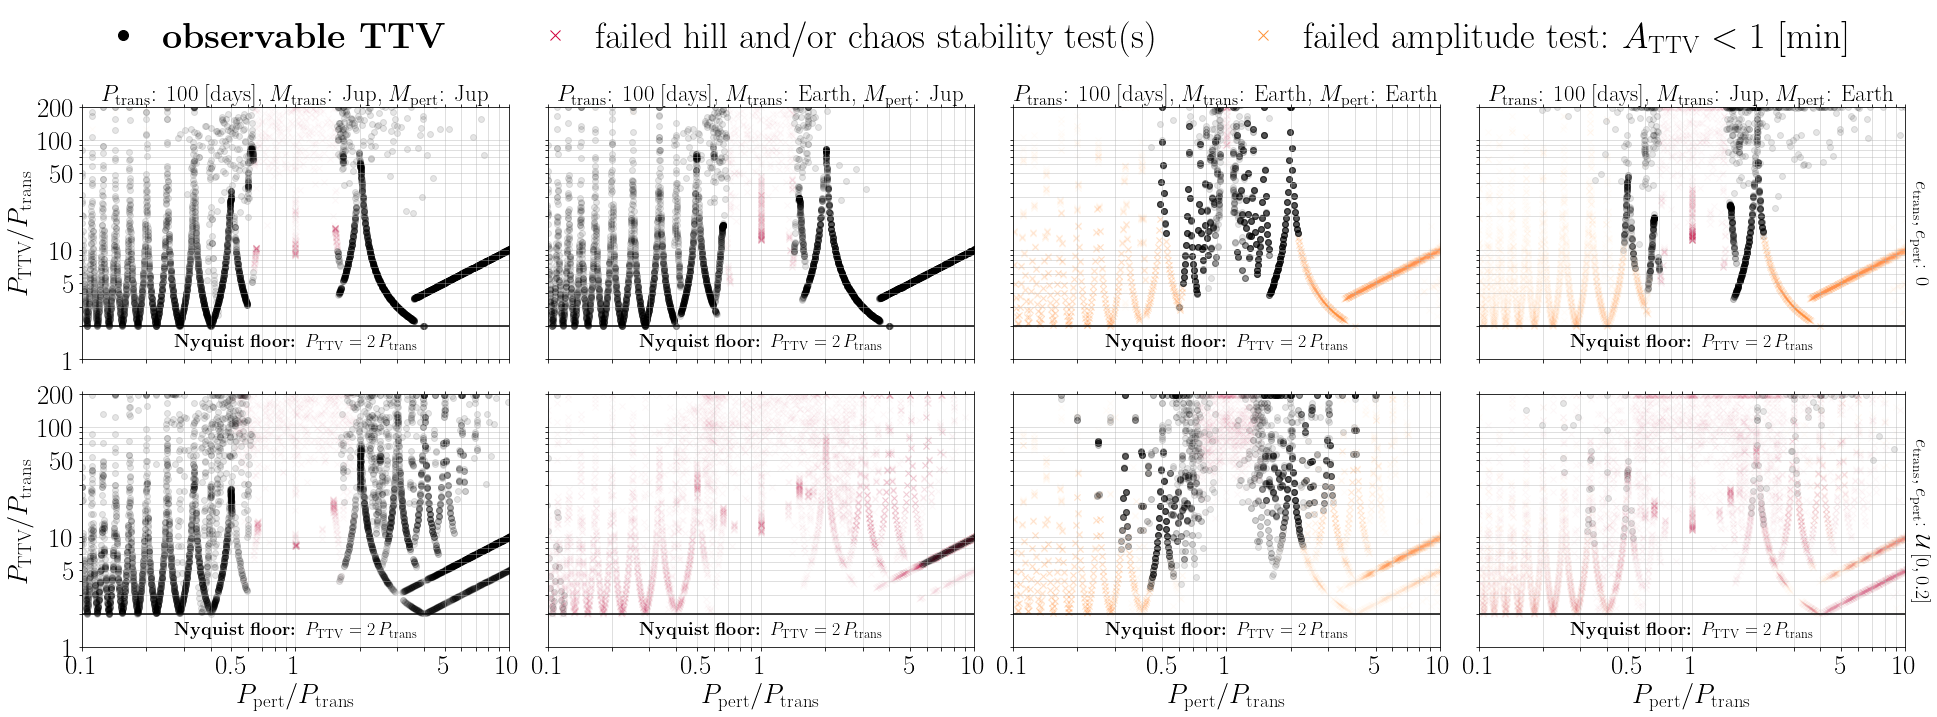

In [91]:
# Directories for each column
directories = [directories1, directories2, directories3, directories4]

# Corresponding data lists for each directory set
orbital_params_all = [orbital_params_all1, orbital_params_all2, orbital_params_all3, orbital_params_all4]
lstsq_ptrans_all = [lstsq_ptrans_all1, lstsq_ptrans_all2, lstsq_ptrans_all3, lstsq_ptrans_all4]
lstsq_ppert_all = [lstsq_ppert_all1, lstsq_ppert_all2, lstsq_ppert_all3, lstsq_ppert_all4]
P_1_ttv_all = [P_1_ttv_all1, P_1_ttv_all2, P_1_ttv_all3, P_1_ttv_all4]
amplitude_ttv_all = [amplitude_ttv_all1, amplitude_ttv_all2, amplitude_ttv_all3, amplitude_ttv_all4]

# Titles for each column
column_titles = [r'$P_\mathrm{trans}$: 100 [days], $M_\mathrm{trans}$: Jup, $M_\mathrm{pert}$: Jup', 
                 r'$P_\mathrm{trans}$: 100 [days], $M_\mathrm{trans}$: Earth, $M_\mathrm{pert}$: Jup', 
                 r'$P_\mathrm{trans}$: 100 [days], $M_\mathrm{trans}$: Earth, $M_\mathrm{pert}$: Earth', 
                 r'$P_\mathrm{trans}$: 100 [days], $M_\mathrm{trans}$: Jup, $M_\mathrm{pert}$: Earth']

# Labels for each row based on e ranges
row_labels = [r'$e_\mathrm{trans}, e_\mathrm{pert}$: 0', 
              r'$e_\mathrm{trans}, e_\mathrm{pert}$: $\mathcal{U} \, [0, 0.2]$']

# Number of subplots in the grid (rows = max length of directories, columns = 4)
n_rows = max(len(d) for d in directories)
n_cols = len(directories)

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=[27, 9], sharex=True, sharey=True)

# Iterate over each directory and its corresponding data
for col, (dir_set, orbital_params, lstsq_ptrans, lstsq_ppert, P_1_ttv, amplitude_ttv) in enumerate(zip(directories, orbital_params_all, lstsq_ptrans_all, lstsq_ppert_all, P_1_ttv_all, amplitude_ttv_all)):
    for row in range(len(dir_set)):
        ax = axs[row, col] if n_rows > 1 else axs[col]  # Select the current subplot
        
        for ii in range(len(P_1_ttv[row])):
            hill_checks = []
            chaos_checks = []

            mu_trans = orbital_params[row][ii][0]
            mu_pert = orbital_params[row][ii][1]
            e_trans = orbital_params[row][ii][2]
            e_pert = orbital_params[row][ii][3]
            w_trans = orbital_params[row][ii][4]
            w_pert = orbital_params[row][ii][5]

            for jj in range(len(lstsq_ppert[row][ii])):
                P_trans = lstsq_ptrans[row][ii][jj]
                P_pert = lstsq_ppert[row][ii][jj]
                
                hill_check = hill_stability_check(mu_trans, mu_pert, P_trans, P_pert, e_trans, e_pert)
                chaos_check = chaos_stability_check(mu_trans, mu_pert, P_trans, P_pert, e_trans, e_pert, w_trans, w_pert)
                
                hill_checks.append(hill_check)
                chaos_checks.append(chaos_check)
            
            ppert_over_ptrans = np.array(lstsq_ppert[row][ii]) / np.array(lstsq_ptrans[row][ii])
            P1ttv = np.array(P_1_ttv[row][ii])
            amp_ttv = np.array(amplitude_ttv[row][ii])
            
            hill_checks = np.array(hill_checks)
            chaos_checks = np.array(chaos_checks)
            
            if hill_checks.size > 0 and chaos_checks.size > 0:
                # Find indices where both hill_check and chaos_check are True
                initial_selected_indices = np.where(hill_checks & chaos_checks)[0]
                
                if amp_ttv.size > 0:
                    # Further filter to include only where amplitude_ttv > 10/60 -- or 10 seconds
                    selected_indices = initial_selected_indices[amp_ttv[initial_selected_indices] > (60./60.)]
                    
                    # Determine indices excluded due to amplitude check
                    excluded_due_to_amplitude = np.setdiff1d(initial_selected_indices, selected_indices)
                    
                    # Determine indices failing due to stability checks
                    excluded_due_to_stability = np.setdiff1d(np.arange(ppert_over_ptrans.size), initial_selected_indices)
                else:
                    selected_indices = np.array([])
                    excluded_due_to_amplitude = initial_selected_indices
                    excluded_due_to_stability = np.arange(ppert_over_ptrans.size)
            else:
                selected_indices = np.array([])
                excluded_due_to_amplitude = np.array([])
                excluded_due_to_stability = np.arange(ppert_over_ptrans.size)
                
            # Plot the selected points
            if selected_indices.size > 0:
                ax.plot(ppert_over_ptrans[selected_indices], P1ttv[selected_indices], color='k', alpha=.1, ls='', marker='o', zorder = 1)
            
            # Plot the non-selected points in red (due to stability checks)
            if excluded_due_to_stability.size > 0:
                ax.plot(ppert_over_ptrans[excluded_due_to_stability], P1ttv[excluded_due_to_stability], color='#d1003c', alpha=.03, ls='', marker='x', zorder=-10000)
                    
            # Plot the non-selected points in orange (due to amplitude checks)
            if excluded_due_to_amplitude.size > 0:
                ax.plot(ppert_over_ptrans[excluded_due_to_amplitude], P1ttv[excluded_due_to_amplitude], color='#ff9338', alpha=.03, ls='', marker='x', zorder=-10000)

        # plot Nyquist floor
        ax.axhline(2, 0, 1, color='k')
        ax.text(1, 1.3, r'\textbf{Nyquist floor: $P_\mathrm{TTV} = 2 \, P_\mathrm{trans}$}', fontsize=18, ha='center', color='k')


        
        # Set plot properties
        ax.set_yscale("log", base=10)
        ax.set_xscale("log", base=10)
        ax.set_xlim(.1, 10)
        ax.set_ylim(1, 200)
        ax.set_xticks([.1, .2, .3, .4, .5, .6, .7, .8, .9, 
                       1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
        ax.set_xticklabels([.1, '', '', '', .5, '', '', '', '', 
                            1, '', '', '', 5, '', '', '', '', 10])
        ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
                       10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200])
        ax.set_yticklabels([1, '', '', '', 5, '', '', '', '',
                            10, '', '', '', 50, '', '', '', '', 100, 200])
        ax.tick_params(axis='x', which='both', bottom=True, top=True)
        ax.tick_params(axis='y', which='both', bottom=True, top=True)
        
        if row == n_rows - 1:
            ax.set_xlabel(r'$P_\mathrm{pert}/P_\mathrm{trans}$', fontsize=27)
        if col == 0:
            ax.set_ylabel(r'$P_\mathrm{TTV}/P_\mathrm{trans}$', fontsize=27)
        
        ax.grid(True, alpha=0.5)
        
        # Annotate row labels on the right side
        if col == n_cols - 1:
            ax.annotate(row_labels[row], xy=(1.01, 0.5), xycoords='axes fraction', 
                        fontsize=20, ha='left', va='center', rotation=270)

    # Set the title for the top row subplots
    axs[0, col].set_title(column_titles[col], fontsize=23)

# Create a custom legend with alpha=1 for markers
legend_elements = [
    plt.Line2D([0], [0], color='k', marker='o', linestyle='', markersize=10, label=r'\textbf{observable TTV}', alpha=1),
    plt.Line2D([0], [0], color='#d1003c', marker='x', linestyle='', markersize=10, label=r'failed hill and/or chaos stability test(s)', alpha=1),
    plt.Line2D([0], [0], color='#ff9338', marker='x', linestyle='', markersize=10, label=r'failed amplitude test: $A_\mathrm{TTV}$ $<$ 1 [min]', alpha=1)
]

# Add the legend to the figure
fig.legend(handles=legend_elements, loc='upper center', fontsize=36, ncol=3, 
           bbox_to_anchor=(0.5, 1.13), frameon=False, handletextpad=0.1) 
           #title=r'$P_\mathrm{trans}$: 100 [days]', title_fontsize=36)


# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)  # Modify wspace and hspace to reduce space between subplots



# Adjust layout to prevent overlap and fit the legend as the title
fig.tight_layout(rect=[0, 0, 1, 1])  # Adjust the top space to fit the legend

# Optionally save the figure
plt.savefig('./figures/orbital_landscape_masses.pdf', bbox_inches='tight')

# Show the plot
plt.show()



In [25]:
#super period
def super_period(P1, P2, j, k):
    return 1/np.abs((j/P1) - (k/P2))


#normalized super period to P1
def super_period_norm(P2P1, j, k):
    return 1/np.abs((j) - (k/P2P1))

#normalized super period to P1 and where n now represents the order
#n = 1 means j:j-1 orbit
#n = -1 means j:j+1 orbit
def super_period_norm_order(P2P1, j, n):
    return 1/np.abs((j) - (j-n/P2P1))


#we can solve for j as the nearest resonance to k... 
#since P1/P2 ~ j/k, then j ~ k*(P1/P2) = k/P2P1
def j_nearest_k(P2P1, k):
    return np.round(k/P2P1)

#we can solve for k as the nearest resonance to j... 
#since P1/P2 ~ j/k, then k ~ j/(P1/P2) = k*P2P1
def k_nearest_j(P2P1, k):
    return np.round(k * P2P1)


#aliasing formula
def alias_period(Pttv, m):
    return 1/np.abs((1/Pttv) + m)



#chopping period
def chopping_period(P1, P2):
    return 1/np.abs((1/P1) - (1/P2))


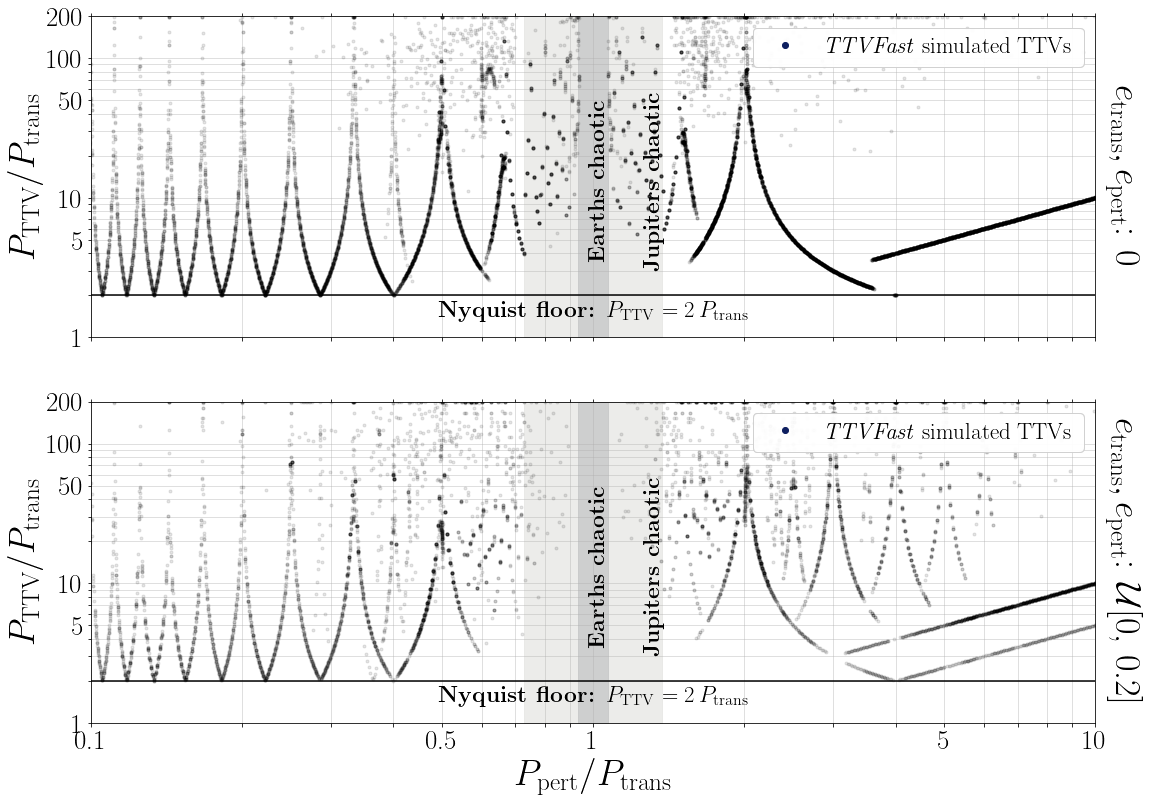

In [93]:
import matplotlib.lines as mlines

# Directories for each column
directories = [directories1, directories2, directories3, directories4]

# Corresponding data lists for each directory set
orbital_params_all = [orbital_params_all1, orbital_params_all2, orbital_params_all3, orbital_params_all4]
lstsq_ptrans_all = [lstsq_ptrans_all1, lstsq_ptrans_all2, lstsq_ptrans_all3, lstsq_ptrans_all4]
lstsq_ppert_all = [lstsq_ppert_all1, lstsq_ppert_all2, lstsq_ppert_all3, lstsq_ppert_all4]
P_1_ttv_all = [P_1_ttv_all1, P_1_ttv_all2, P_1_ttv_all3, P_1_ttv_all4]
amplitude_ttv_all = [amplitude_ttv_all1, amplitude_ttv_all2, amplitude_ttv_all3, amplitude_ttv_all4]



# Initialize lists to store combined filtered data
combined_ppert_over_ptrans = []
combined_P1ttv = []

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=[18, 13], sharex=True)

# Subplot 1: Loop through a range of rows (e.g., first 1 row)
for col, (dir_set, orbital_params, lstsq_ptrans, lstsq_ppert, P_1_ttv, amplitude_ttv) in enumerate(zip(directories, orbital_params_all, lstsq_ptrans_all, lstsq_ppert_all, P_1_ttv_all, amplitude_ttv_all)):
    for row in range(0,1):  # Adjust range to loop through the first 1 rows only
        for ii in range(len(P_1_ttv[row])):
            hill_checks = []
            chaos_checks = []

            mu_trans = orbital_params[row][ii][0]
            mu_pert = orbital_params[row][ii][1]
            e_trans = orbital_params[row][ii][2]
            e_pert = orbital_params[row][ii][3]
            w_trans = orbital_params[row][ii][4]
            w_pert = orbital_params[row][ii][5]

            for jj in range(len(lstsq_ppert[row][ii])):
                P_trans = lstsq_ptrans[row][ii][jj]
                P_pert = lstsq_ppert[row][ii][jj]

                hill_check = hill_stability_check(mu_trans, mu_pert, P_trans, P_pert, e_trans, e_pert)
                chaos_check = chaos_stability_check(mu_trans, mu_pert, P_trans, P_pert, e_trans, e_pert, w_trans, w_pert)

                hill_checks.append(hill_check)
                chaos_checks.append(chaos_check)

            ppert_over_ptrans = np.array(lstsq_ppert[row][ii]) / np.array(lstsq_ptrans[row][ii])
            P1ttv = np.array(P_1_ttv[row][ii])
            amp_ttv = np.array(amplitude_ttv[row][ii])

            hill_checks = np.array(hill_checks)
            chaos_checks = np.array(chaos_checks)

            if hill_checks.size > 0 and chaos_checks.size > 0:
                # Find indices where both hill_check and chaos_check are True
                initial_selected_indices = np.where(hill_checks & chaos_checks)[0]

                # Further filter to include only where amplitude_ttv > 10/60 -- or 10 seconds
                if amp_ttv.size > 0:
                    selected_indices = initial_selected_indices[amp_ttv[initial_selected_indices] > (60./60.)]

                    # Add selected data to combined lists
                    combined_ppert_over_ptrans.extend(ppert_over_ptrans[selected_indices])
                    combined_P1ttv.extend(P1ttv[selected_indices])

# Convert lists to numpy arrays for plotting
combined_ppert_over_ptrans = np.array(combined_ppert_over_ptrans)
combined_P1ttv = np.array(combined_P1ttv)

# Plot the combined filtered data in the first subplot
if combined_ppert_over_ptrans.size > 0 and combined_P1ttv.size > 0:
    line0 = axs[0].plot(combined_ppert_over_ptrans, combined_P1ttv, color='k', alpha=.1, ls='', marker='.',
                        label = r'\textit{TTVFast} simulated TTVs')

# Repeat the above process for all rows in the second subplot
combined_ppert_over_ptrans = []
combined_P1ttv = []



    
# plot Nyquist floor
axs[0].axhline(2, 0, 1, color='k')
axs[0].text(1, 1.4, r'\textbf{Nyquist floor: $P_\mathrm{TTV} = 2 \, P_\mathrm{trans}$}', fontsize=23, ha='center', color='k')



ecc_label = r'$e_\mathrm{trans}, e_\mathrm{pert}$: 0'
axs[0].annotate(ecc_label, xy=(1.01, 0.5), xycoords='axes fraction', fontsize=36, ha='left', va='center', rotation=270)










# Subplot 2: Loop through a range of rows (e.g., first 2 rows)
for col, (dir_set, orbital_params, lstsq_ptrans, lstsq_ppert, P_1_ttv, amplitude_ttv) in enumerate(zip(directories, orbital_params_all, lstsq_ptrans_all, lstsq_ppert_all, P_1_ttv_all, amplitude_ttv_all)):
    for row in range(1,2):  # Adjust range to loop through the first 2 rows only
        for ii in range(len(P_1_ttv[row])):
            hill_checks = []
            chaos_checks = []

            mu_trans = orbital_params[row][ii][0]
            mu_pert = orbital_params[row][ii][1]
            e_trans = orbital_params[row][ii][2]
            e_pert = orbital_params[row][ii][3]
            w_trans = orbital_params[row][ii][4]
            w_pert = orbital_params[row][ii][5]

            for jj in range(len(lstsq_ppert[row][ii])):
                P_trans = lstsq_ptrans[row][ii][jj]
                P_pert = lstsq_ppert[row][ii][jj]

                hill_check = hill_stability_check(mu_trans, mu_pert, P_trans, P_pert, e_trans, e_pert)
                chaos_check = chaos_stability_check(mu_trans, mu_pert, P_trans, P_pert, e_trans, e_pert, w_trans, w_pert)

                hill_checks.append(hill_check)
                chaos_checks.append(chaos_check)

            ppert_over_ptrans = np.array(lstsq_ppert[row][ii]) / np.array(lstsq_ptrans[row][ii])
            P1ttv = np.array(P_1_ttv[row][ii])
            amp_ttv = np.array(amplitude_ttv[row][ii])

            hill_checks = np.array(hill_checks)
            chaos_checks = np.array(chaos_checks)

            if hill_checks.size > 0 and chaos_checks.size > 0:
                # Find indices where both hill_check and chaos_check are True
                initial_selected_indices = np.where(hill_checks & chaos_checks)[0]

                # Further filter to include only where amplitude_ttv > 10/60 -- or 10 seconds
                if amp_ttv.size > 0:
                    selected_indices = initial_selected_indices[amp_ttv[initial_selected_indices] > (60./60.)]

                    # Add selected data to combined lists
                    combined_ppert_over_ptrans.extend(ppert_over_ptrans[selected_indices])
                    combined_P1ttv.extend(P1ttv[selected_indices])

# Convert lists to numpy arrays for plotting
combined_ppert_over_ptrans = np.array(combined_ppert_over_ptrans)
combined_P1ttv = np.array(combined_P1ttv)

# Plot the combined filtered data in the first subplot
if combined_ppert_over_ptrans.size > 0 and combined_P1ttv.size > 0:
    line0 = axs[1].plot(combined_ppert_over_ptrans, combined_P1ttv, color='k', alpha=.1, ls='', marker='.',
                        label = r'\textit{TTVFast} simulated TTVs')

# Repeat the above process for all rows in the second subplot
combined_ppert_over_ptrans = []
combined_P1ttv = []



    
# plot Nyquist floor
axs[1].axhline(2, 0, 1, color='k')
axs[1].text(1, 1.4, r'\textbf{Nyquist floor: $P_\mathrm{TTV} = 2 \, P_\mathrm{trans}$}', fontsize=23, ha='center', color='k')


ecc_label = r'$e_\mathrm{trans}, e_\mathrm{pert}$: $\mathcal{U}$[0, 0.2]'
axs[1].annotate(ecc_label, xy=(1.01, 0.5), xycoords='axes fraction', fontsize=36, ha='left', va='center', rotation=270)








#determine instability from overlapping resonances Deck+2013 eq 49
jup_ratio = 1+2.2*(2*1e-3)**(2/7)
earth_ratio = 1+2.2*(2*3e-6)**(2/7)

# Shade between 1.05 and 1/1.05 (grey) and 1.3 and 1/1.3 (lighter grey)
axs[0].fill_betweenx([1, 200], 1/earth_ratio, earth_ratio, color='#71797E', alpha=.7)  # Jupiter mass chaotic region
axs[0].fill_betweenx([1, 200], 1/jup_ratio, jup_ratio, color='#E5E4E2', alpha=.7)  # Earth mass chaotic region
axs[1].fill_betweenx([1, 200], 1/earth_ratio, earth_ratio, color='#71797E', alpha=.7)  # Jupiter mass chaotic region
axs[1].fill_betweenx([1, 200], 1/jup_ratio, jup_ratio, color='#E5E4E2', alpha=.7)  # Earth mass chaotic region


# Add vertical labels inside the shaded regions
axs[0].text(earth_ratio-.05, 13, r'\textbf{Earths chaotic}', color='black', fontsize=23, ha='center', va='center', rotation=90)
axs[0].text(jup_ratio-.05, 13, r'\textbf{Jupiters chaotic}', color='black', fontsize=23, ha='center', va='center', rotation=90)
axs[1].text(earth_ratio-.05, 13, r'\textbf{Earths chaotic}', color='black', fontsize=23, ha='center', va='center', rotation=90)
axs[1].text(jup_ratio-.05, 13, r'\textbf{Jupiters chaotic}', color='black', fontsize=23, ha='center', va='center', rotation=90)









    
    
    
    
# Set plot properties for both subplots
for ax in axs:
    ax.set_yscale("log", base=10)
    ax.set_xscale("log", base=10)
    ax.set_xlim(.1, 10)
    ax.set_ylim(1, 200)
    ax.set_xticks([.1, .2, .3, .4, .5, .6, .7, .8, .9, 
                   1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    ax.set_xticklabels([.1, '', '', '', .5, '', '', '', '', 
                        1, '', '', '', 5, '', '', '', '', 10])
    ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
                   10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200])
    ax.set_yticklabels([1, '', '', '', 5, '', '', '', '',
                        10, '', '', '', 50, '', '', '', '', 100, 200])
    ax.tick_params(axis='x', which='both', bottom=True, top=True)
    ax.tick_params(axis='y', which='both', bottom=True, top=True)

    ax.grid(True, alpha=0.5)

axs[0].set_ylabel(r'$P_\mathrm{TTV}/P_\mathrm{trans}$', fontsize=36)
axs[1].set_ylabel(r'$P_\mathrm{TTV}/P_\mathrm{trans}$', fontsize=36)
axs[1].set_xlabel(r'$P_\mathrm{pert}/P_\mathrm{trans}$', fontsize=36)



# Custom proxy artist for the legend with alpha=1
ttvfast_legend_marker = mlines.Line2D([], [], color='#0e1f60', marker='o', linestyle='', alpha=1, label=r'\textit{TTVFast} simulated TTVs')

# Add the legend to top subplot
lines = [ttvfast_legend_marker]
labs = [line.get_label() for line in lines]
legend = axs[0].legend(lines, labs, fontsize=23, loc=1)
axs[0].add_artist(legend)

# Add the legend to middle subplot
lines = [ttvfast_legend_marker]
labs = [line.get_label() for line in lines]
legend = axs[1].legend(lines, labs, fontsize=23, loc=1)
axs[1].add_artist(legend)


# Optionally save the figure
plt.savefig('./figures/orbital_landscape_combined.pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [6]:
# Create the pandas DataFrame
holczer = pd.read_csv('./holczer_LS_fit_Aug2024.csv')


# Display the DataFrame
holczer


,KOI,P_ttv [cycles],amplitude_ttv [min],delta_BIC,P_lin,P_ttv [days]
0,1.01,2.853920,0.014495,-8.336251,2.470613,7.050934
1,2.01,2.009103,0.048569,1.905050,2.204735,4.429541
2,3.01,3.139865,0.102346,13.245529,4.887803,15.347040
3,5.01,10.890161,0.547617,-0.504880,4.780329,52.058552
4,7.01,12.710475,1.033167,2.070013,3.213667,40.847238
...,...,...,...,...,...,...
2593,5958.01,NaN,NaN,NaN,NaN,NaN
2594,5959.01,2.554113,71.884221,16.715621,251.479044,642.305784
2595,5968.01,2.819939,49.689695,9.243937,97.943227,276.193921
2596,5969.01,12.000000,137.573904,1.755848,163.847154,1966.165851


In [7]:
#remove all rows where delta_bic < 6
holczer = holczer[holczer['delta_BIC'] >= 6]


# Display the DataFrame
holczer



,KOI,P_ttv [cycles],amplitude_ttv [min],delta_BIC,P_lin,P_ttv [days]
2,3.01,3.139865,0.102346,13.245529,4.887803,15.347040
6,12.01,67.688296,1.099880,231.448853,17.855222,1208.589575
11,22.01,2.674241,0.188001,7.841270,7.891448,21.103631
13,41.02,2.477812,20.301224,77.820408,6.887074,17.064872
14,41.03,2.225735,40.595279,54.392998,35.331442,78.638412
...,...,...,...,...,...,...
2589,5945.01,6.306069,55.343619,53.889574,40.720190,256.784314
2591,5952.01,2.728324,79.162312,24.557560,164.494763,448.794961
2592,5955.01,2.544681,37.596454,19.737412,96.327323,245.122293
2594,5959.01,2.554113,71.884221,16.715621,251.479044,642.305784


In [8]:
import pandas as pd

# Load the data
exoplanet_archive_kois = pd.read_csv('./kois_exoplanet_archive_2024.08.30.csv', skiprows=17)

# Print the length before removing FALSE POSITIVE rows
print('KOIs before removing FALSE POSITIVE rows:', len(exoplanet_archive_kois))

# Remove any rows where koi_disposition equals 'FALSE POSITIVE'
exoplanet_archive_kois = exoplanet_archive_kois[exoplanet_archive_kois['koi_disposition'] != 'FALSE POSITIVE']

# Print the length after removing FALSE POSITIVE rows
print('KOIs after removing FALSE POSITIVE rows:', len(exoplanet_archive_kois))


# Remove the 'K' and leading zeros from the kepoi_name column
exoplanet_archive_kois['kepoi_name_cleaned'] = exoplanet_archive_kois['kepoi_name'].str.replace('K', '').str.lstrip('0').astype(float)

# add a KOI ID for the star to track number of planets per star
exoplanet_archive_kois['kepoi_star'] = exoplanet_archive_kois['kepoi_name'].str.split('.').str[0]


# Determine the number of planets (n_planets) for each unique value of kepoi_star
exoplanet_archive_kois['n_planets'] = exoplanet_archive_kois.groupby('kepoi_star')['kepoi_star'].transform('count')



KOIs before removing FALSE POSITIVE rows: 9564
KOIs after removing FALSE POSITIVE rows: 4725


In [9]:
exoplanet_archive_kois

,loc_rowid,kepoi_name,koi_disposition,koi_period,koi_period_err1,koi_period_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_srad,koi_srad_err1,koi_srad_err2,kepoi_name_cleaned,kepoi_star,n_planets
0,1,K00752.01,CONFIRMED,9.488036,0.000028,-0.000028,2.26,0.26,-0.15,0.927,0.105,-0.061,752.01,K00752,2
1,2,K00752.02,CONFIRMED,54.418383,0.000248,-0.000248,2.83,0.32,-0.19,0.927,0.105,-0.061,752.02,K00752,2
2,3,K00753.01,CANDIDATE,19.899140,0.000015,-0.000015,14.60,3.92,-1.31,0.868,0.233,-0.078,753.01,K00753,1
4,5,K00755.01,CONFIRMED,2.525592,0.000004,-0.000004,2.75,0.88,-0.35,1.046,0.334,-0.133,755.01,K00755,1
5,6,K00756.01,CONFIRMED,11.094321,0.000020,-0.000020,3.90,1.27,-0.42,0.972,0.315,-0.105,756.01,K00756,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9538,9539,K07978.01,CANDIDATE,7.268182,0.000163,-0.000163,1.66,0.40,-0.74,2.219,0.536,-0.996,7978.01,K07978,1
9542,9543,K07982.01,CANDIDATE,376.379890,0.046800,-0.046800,3.26,1.00,-0.33,0.955,0.291,-0.097,7982.01,K07982,1
9552,9553,K08193.01,CANDIDATE,367.947848,0.004787,-0.004787,3.72,0.90,-0.30,0.855,0.207,-0.069,8193.01,K08193,1
9560,9561,K07986.01,CANDIDATE,1.739849,0.000018,-0.000018,0.72,0.24,-0.08,1.031,0.341,-0.114,7986.01,K07986,1


In [10]:
exoplanet_archive_kois.loc[exoplanet_archive_kois['kepoi_name_cleaned'] == 326.01]['koi_disposition'].values



array([], dtype=object)

In [11]:

# Create an empty DataFrame with the specified columns
columns = ['KOI', 'P_ttv [cycles]', 'amplitude_ttv [min]', 'delta_BIC', 'P_lin [days]', 'P_ttv [days]', 'P_lin_archive [days]']
holczer_singles = pd.DataFrame(columns=columns)
holczer_2planet = pd.DataFrame(columns=columns)
holczer_multis = pd.DataFrame(columns=columns)
holczer_all = pd.DataFrame(columns=columns)

false_positives_in_holczer = 0
for index, row in holczer.iterrows():
    koi = row['KOI']
    row_dict = {col: value for col, value in zip(columns, row)}
    
    # Check if the koi is in exoplanet_archive_kois['kepoi_name_cleaned']
    if koi not in exoplanet_archive_kois['kepoi_name_cleaned'].values:
        false_positives_in_holczer+=1
        continue  # Skip this row if koi is not found

    period = exoplanet_archive_kois.loc[
        exoplanet_archive_kois['kepoi_name_cleaned'] == koi]['koi_period'].values[0]
    disposition = exoplanet_archive_kois.loc[
        exoplanet_archive_kois['kepoi_name_cleaned'] == koi]['koi_disposition'].values[0]
    nplanets = exoplanet_archive_kois.loc[
        exoplanet_archive_kois['kepoi_name_cleaned'] == koi]['n_planets'].values[0]
    koi_star = exoplanet_archive_kois.loc[
        exoplanet_archive_kois['kepoi_name_cleaned'] == koi]['kepoi_star'].values[0]
    
    
    

    # Append the value for 'P_lin_archive [days]' from the list to each row
    row_dict['P_lin_archive [days]'] = period

    
    if disposition != 'FALSE POSITIVE':
        if nplanets > 1:
            # Find rows that have the same kepoi_star value
            matching_star_rows = exoplanet_archive_kois[exoplanet_archive_kois['kepoi_star'] == koi_star]

            # Filter out the row with the same kepoi_name_cleaned value
            other_row = matching_star_rows[matching_star_rows['kepoi_name_cleaned'] != koi]
            

            for companion_koi in other_row['kepoi_name_cleaned'].values:
                companion_row = matching_star_rows[matching_star_rows['kepoi_name_cleaned'] == companion_koi]
                row_dict['planet ' + str(companion_koi).split(".")[1] + ' P_pert_archive [days]'] = companion_row['koi_period'].values[0]

            holczer_multis = holczer_multis.append(row_dict, ignore_index=True)
            holczer_all = holczer_all.append(row_dict, ignore_index=True)
            
        if nplanets == 2:
            # Find rows that have the same kepoi_star value
            matching_star_rows = exoplanet_archive_kois[exoplanet_archive_kois['kepoi_star'] == koi_star]

            # Filter out the row with the same kepoi_name_cleaned value
            other_row = matching_star_rows[matching_star_rows['kepoi_name_cleaned'] != koi]
                
            # Append the value for 'P_lin_archive [days]' from the list to each row
            row_dict['P_pert_archive [days]'] = other_row['koi_period'].values[0]

            holczer_2planet = holczer_2planet.append(row_dict, ignore_index=True)

            
        if nplanets == 1:
            holczer_singles = holczer_singles.append(row_dict, ignore_index=True)
            holczer_all = holczer_all.append(row_dict, ignore_index=True)

            
            
    else:
        print(koi)
        print(disposition != 'FALSE POSITIVE')
            







print('total kois in holczer to start:')
print(len(holczer))
print('')

print('false positives in holczer:')
print(false_positives_in_holczer)
print('')

print('n holczer multis:')
print(len(holczer_multis))
print('')

print('n holczer singles:')
print(len(holczer_singles))
print('')

print('n holczer doubles:')
print(len(holczer_2planet))
print('')

print('n holczer multis + singles + FPs:')
print(len(holczer_multis)+len(holczer_singles)+false_positives_in_holczer)


AttributeError: 'DataFrame' object has no attribute 'append'

In [115]:
# Save the DataFrame to a CSV file
holczer_all.to_csv('holczer_exoplanet_archive_match_Aug2024.csv', index=False)

In [116]:
# Filtering based on the condition
holczer_2planet_edges_only = holczer_2planet[holczer_2planet['P_pert_archive [days]'] > 2 * holczer_2planet['P_lin_archive [days]']]

# Displaying the resulting DataFrame
holczer_2planet_edges_only


,KOI,P_ttv [cycles],amplitude_ttv [min],delta_BIC,P_lin [days],P_ttv [days],P_lin_archive [days],P_pert_archive [days],planet 02 P_pert_archive [days],planet 01 P_pert_archive [days],planet 03 P_pert_archive [days]
1,72.01,17.901689,1.371332,10.021066,0.837491,14.992507,0.837491,45.294223,45.294223,NaN,NaN
3,89.01,6.505415,9.652289,11.588111,84.688106,550.931286,84.687752,207.582931,207.582931,NaN,NaN
5,102.01,34.436056,0.549569,6.933483,1.735136,59.751243,1.735136,4.068450,4.068450,NaN,NaN
7,112.02,4.068468,7.303715,7.868017,3.709196,15.090747,3.709214,51.079265,NaN,51.079265,NaN
8,119.01,4.097021,2.522242,12.718444,49.183948,201.507682,49.183942,190.320047,190.320047,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
303,2687.01,4.053578,5.150985,12.642808,1.716833,6.959317,1.716828,8.167339,8.167339,NaN,NaN
307,2696.02,18.325180,15.103242,18.909112,44.565421,816.669349,44.564383,96.456220,NaN,96.456220,NaN
314,3214.01,26.966513,44.559901,22.925405,11.494553,309.968002,11.495002,25.090157,25.090157,NaN,NaN
321,3681.02,3.886496,29.380277,75.053773,10.514106,40.863027,10.514212,217.831843,NaN,217.831843,NaN


In [117]:
holczer_2planet_edges_only['period_ratio'] = holczer_2planet_edges_only['P_pert_archive [days]'] / holczer_2planet_edges_only['P_lin_archive [days]']
holczer_2planet_edges_only




/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_75972/1461205650.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holczer_2planet_edges_only['period_ratio'] = holczer_2planet_edges_only['P_pert_archive [days]'] / holczer_2planet_edges_only['P_lin_archive [days]']


,KOI,P_ttv [cycles],amplitude_ttv [min],delta_BIC,P_lin [days],P_ttv [days],P_lin_archive [days],P_pert_archive [days],planet 02 P_pert_archive [days],planet 01 P_pert_archive [days],planet 03 P_pert_archive [days],period_ratio
1,72.01,17.901689,1.371332,10.021066,0.837491,14.992507,0.837491,45.294223,45.294223,NaN,NaN,54.083221
3,89.01,6.505415,9.652289,11.588111,84.688106,550.931286,84.687752,207.582931,207.582931,NaN,NaN,2.451156
5,102.01,34.436056,0.549569,6.933483,1.735136,59.751243,1.735136,4.068450,4.068450,NaN,NaN,2.344744
7,112.02,4.068468,7.303715,7.868017,3.709196,15.090747,3.709214,51.079265,NaN,51.079265,NaN,13.770913
8,119.01,4.097021,2.522242,12.718444,49.183948,201.507682,49.183942,190.320047,190.320047,NaN,NaN,3.869557
...,...,...,...,...,...,...,...,...,...,...,...,...
303,2687.01,4.053578,5.150985,12.642808,1.716833,6.959317,1.716828,8.167339,8.167339,NaN,NaN,4.757225
307,2696.02,18.325180,15.103242,18.909112,44.565421,816.669349,44.564383,96.456220,NaN,96.456220,NaN,2.164424
314,3214.01,26.966513,44.559901,22.925405,11.494553,309.968002,11.495002,25.090157,25.090157,NaN,NaN,2.182701
321,3681.02,3.886496,29.380277,75.053773,10.514106,40.863027,10.514212,217.831843,NaN,217.831843,NaN,20.717848


In [118]:
# Selecting rows where 'P_ttv [cycles]' is less than 'P_pert_archive [days]'
holczer_2planet_edges_not_like = holczer_2planet_edges_only[holczer_2planet_edges_only['P_ttv [cycles]'] > 1.1*
                                                            holczer_2planet_edges_only['period_ratio']]


print(len(holczer_2planet_edges_not_like))
holczer_2planet_edges_not_like

52


,KOI,P_ttv [cycles],amplitude_ttv [min],delta_BIC,P_lin [days],P_ttv [days],P_lin_archive [days],P_pert_archive [days],planet 02 P_pert_archive [days],planet 01 P_pert_archive [days],planet 03 P_pert_archive [days],period_ratio
3,89.01,6.505415,9.652289,11.588111,84.688106,550.931286,84.687752,207.582931,207.582931,NaN,NaN,2.451156
5,102.01,34.436056,0.549569,6.933483,1.735136,59.751243,1.735136,4.068450,4.068450,NaN,NaN,2.344744
12,150.01,30.917936,2.524282,7.332556,8.408870,259.984918,8.408878,28.574269,28.574269,NaN,NaN,3.398107
14,171.01,2.733181,3.283761,6.487229,5.968705,16.313549,5.968724,13.071419,13.071419,NaN,NaN,2.189985
23,244.02,51.825095,3.968730,179.572513,6.238535,323.312653,6.238535,12.720370,NaN,12.720370,NaN,2.038999
31,275.01,35.991416,9.434347,15.247808,15.791959,568.374964,15.791966,82.200124,82.200124,NaN,NaN,5.205186
34,291.02,4.548066,14.862262,13.771106,8.129918,36.975403,8.129999,31.517795,NaN,31.517795,NaN,3.876728
37,298.01,3.177146,8.720137,10.775608,19.963671,63.427492,19.963672,57.384037,57.384037,NaN,NaN,2.874423
75,508.01,3.860931,4.200503,6.323657,7.930576,30.619411,7.930584,16.665899,16.665899,NaN,NaN,2.101472
81,534.02,5.763584,7.621228,8.932658,2.735900,15.768588,2.735900,6.400157,NaN,6.400157,NaN,2.339324


In [119]:
# Selecting rows where 'P_ttv [cycles]' is less than 'P_pert_archive [days]'
holczer_2planet_edges_like = holczer_2planet_edges_only[holczer_2planet_edges_only['P_ttv [cycles]'] < 1.1*
                                                            holczer_2planet_edges_only['period_ratio']]


# Selecting rows where 'P_ttv [cycles]' is less than 'P_pert_archive [days]'
holczer_2planet_edges_like = holczer_2planet_edges_like[holczer_2planet_edges_like['P_ttv [cycles]'] > 
                                                            holczer_2planet_edges_like['period_ratio']/(2*1.1)]




print(len(holczer_2planet_edges_like))
holczer_2planet_edges_like


32


,KOI,P_ttv [cycles],amplitude_ttv [min],delta_BIC,P_lin [days],P_ttv [days],P_lin_archive [days],P_pert_archive [days],planet 02 P_pert_archive [days],planet 01 P_pert_archive [days],planet 03 P_pert_archive [days],period_ratio
8,119.01,4.097021,2.522242,12.718444,49.183948,201.507682,49.183942,190.320047,190.320047,NaN,NaN,3.869557
17,209.02,2.701590,5.988590,107.510959,18.795878,50.778762,18.795913,50.790346,NaN,50.790346,NaN,2.702202
42,307.02,3.127691,12.872614,17.374436,5.211067,16.298605,5.211046,19.674097,NaN,19.674097,NaN,3.775460
56,354.02,2.027994,32.347639,90.439313,7.378837,14.964240,7.378676,15.959956,NaN,15.959956,NaN,2.162984
71,456.02,3.376835,14.151667,10.915514,4.309388,14.552093,4.309382,13.699423,NaN,13.699423,NaN,3.178976
96,590.01,2.656074,9.420107,9.626580,11.388421,30.248494,11.388402,50.698541,50.698541,NaN,NaN,4.451769
103,645.01,3.008778,14.665676,8.433716,8.503402,25.584846,8.503392,23.783210,23.783210,NaN,NaN,2.796908
125,752.01,3.044410,14.556025,22.233426,9.488064,28.885557,9.488036,54.418383,54.418383,NaN,NaN,5.735474
143,874.01,2.528468,3.888489,9.949238,4.601812,11.635534,4.601812,11.187199,11.187199,NaN,NaN,2.431042
149,951.01,2.582957,2.609025,9.680935,13.197214,34.087837,13.197207,33.652847,33.652847,NaN,NaN,2.549998


In [120]:
# Selecting rows where 'P_ttv [cycles]' is less than 'P_pert_archive [days]'/2 with some room for uncertainty
holczer_2planet_edges_outliers = holczer_2planet_edges_only[holczer_2planet_edges_only['P_ttv [cycles]'] < 
                                                            holczer_2planet_edges_only['period_ratio']/(2*1.1)]

print(len(holczer_2planet_edges_outliers))
holczer_2planet_edges_outliers

13


,KOI,P_ttv [cycles],amplitude_ttv [min],delta_BIC,P_lin [days],P_ttv [days],P_lin_archive [days],P_pert_archive [days],planet 02 P_pert_archive [days],planet 01 P_pert_archive [days],planet 03 P_pert_archive [days],period_ratio
1,72.01,17.901689,1.371332,10.021066,0.837491,14.992507,0.837491,45.294223,45.294223,NaN,NaN,54.083221
7,112.02,4.068468,7.303715,7.868017,3.709196,15.090747,3.709214,51.079265,NaN,51.079265,NaN,13.770913
11,139.02,2.232027,13.148073,48.998598,3.341806,7.459002,3.341799,224.778935,NaN,224.778935,NaN,67.262843
48,327.01,3.018021,7.022971,24.431816,3.254273,9.821465,3.254278,91.351482,91.351482,NaN,NaN,28.071200
66,433.01,2.484893,1.438169,7.886390,4.030468,10.015280,4.030467,328.240201,328.240201,NaN,NaN,81.439748
94,581.01,4.394843,2.674846,8.408748,6.996930,30.750408,6.996926,151.863949,151.863949,NaN,NaN,21.704380
130,790.01,2.491985,5.500458,7.100988,8.472383,21.113052,8.472379,60.418937,60.418937,NaN,NaN,7.131283
145,911.01,5.644078,10.760956,26.978051,4.093565,23.104403,4.093578,105.145959,105.145959,NaN,NaN,25.685585
148,936.02,3.931880,2.251699,7.949744,0.893041,3.511332,0.893041,9.467821,NaN,9.467821,NaN,10.601777
241,1915.01,2.812998,13.122978,47.708832,6.562285,18.459694,6.562265,67.844689,67.844689,NaN,NaN,10.338609


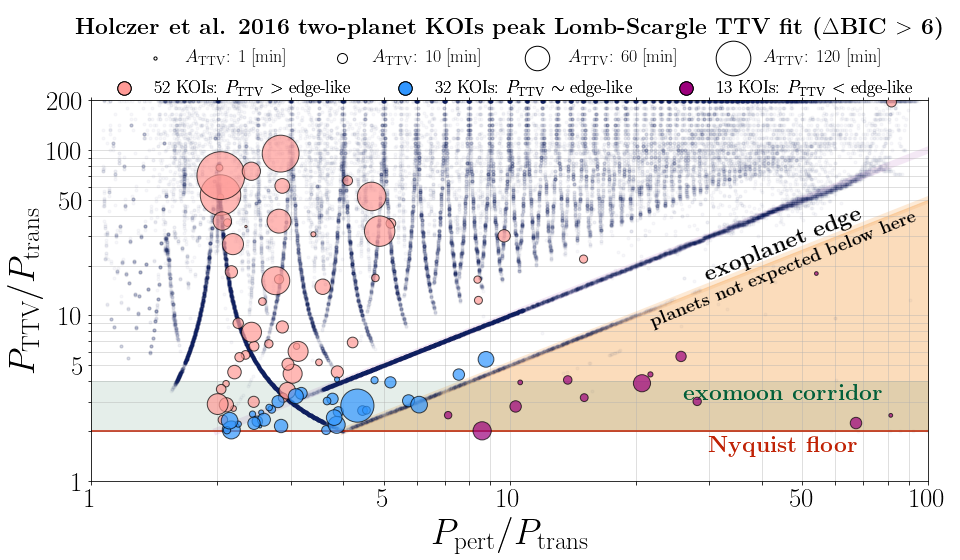

In [186]:
# Create a single plot
fig, ax = plt.subplots(figsize=[15, 7])

    
# Plot the combined filtered data
if combined_ppert_over_ptrans.size > 0 and combined_P1ttv.size > 0:
    ax.plot(combined_ppert_over_ptrans, combined_P1ttv, color='#0e1f60', alpha=.03, ls='', marker='.')

    


    
# plot Nyquist floor
ax.axhline(2, 0, 1, color='#c02205')
ax.text(45, 1.5, r'\textbf{Nyquist floor}', fontsize=23, ha='center', color='#c02205')

# plot the exomoon corridor
ax.axhspan(2, 4, 0, 1, color='#025f3a', alpha=.1)
ax.text(45, 3.1, r'\textbf{exomoon corridor}', color= '#025f3a', fontsize=23, ha='center')

# add exoplanet edges label with a rotation angle
#ax.text(36, 42, r'\textbf{synodic edge}', fontsize=23, rotation=22, color='k', ha='center', va='center')
ax.text(45, 27, r'\textbf{exoplanet edge}', fontsize=23, rotation=22, color='k', ha='center', va='center')
#ax.text(9, 11, r'P$_\mathrm{TTV}$ = P$_\mathrm{pert}$', fontsize=23, rotation=25, color='k', ha='center', va='center')
#ax.text(9, 5.5, r'P$_\mathrm{TTV}$ = P$_\mathrm{pert}$/2', fontsize=23, rotation=25, color='k', ha='center', va='center')


# Set plot properties
ax.set_yscale("log", base=10)
ax.set_xscale("log", base=10)
ax.set_xlim(1, 100)
ax.set_ylim(1, 200)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_xticklabels([1, '', '', '', 5, '', '', '', '',
                    10, '', '', '', 50, '', '', '', '', 100])
ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200])
ax.set_yticklabels([1, '', '', '', 5, '', '', '', '',
                    10, '', '', '', 50, '', '', '', '', 100, 200])
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', bottom=True, top=True)

ax.set_xlabel(r'$P_\mathrm{pert}/P_\mathrm{trans}$', fontsize=36)
ax.set_ylabel(r'$P_\mathrm{TTV}/P_\mathrm{trans}$', fontsize=36)
ax.grid(True, alpha=0.5)




# Scatter plot with color based on 'amplitude' values
ax.scatter(holczer_2planet_edges_not_like['P_pert_archive [days]'] / holczer_2planet_edges_not_like['P_lin_archive [days]'],
           holczer_2planet_edges_not_like['P_ttv [cycles]'], alpha=0.7,
           s=holczer_2planet_edges_not_like['amplitude_ttv [min]'] * 10,  # Scale marker size based on 'amplitude' values
           color='#ff9a96', edgecolors='black', zorder=1000)



# Scatter plot with color based on 'amplitude' values
ax.scatter(holczer_2planet_edges_like['P_pert_archive [days]'] / holczer_2planet_edges_like['P_lin_archive [days]'],
           holczer_2planet_edges_like['P_ttv [cycles]'], alpha=0.7,
           s=holczer_2planet_edges_like['amplitude_ttv [min]'] * 10,  # Scale marker size based on 'amplitude' values
           color='#3096ff', edgecolors='black', zorder=1000)



# Scatter plot with color based on 'amplitude' values
ax.scatter(holczer_2planet_edges_outliers['P_pert_archive [days]'] / holczer_2planet_edges_outliers['P_lin_archive [days]'],
           holczer_2planet_edges_outliers['P_ttv [cycles]'], alpha=0.7,
           s=holczer_2planet_edges_outliers['amplitude_ttv [min]'] * 10,  # Scale marker size based on 'amplitude' values
           color='#9c007c', edgecolors='black', zorder=1000)




# plot rotating-tidal induced TTV
count = 0
p2p1_tides = np.arange(4, 100, .0001)
line2 = ax.plot(p2p1_tides, p2p1_tides/2., color='#f9ba79', lw=7, ls='-',
                label = r'$P_\mathrm{TTV} = P_\mathrm{pert}/2$', zorder=-1000000, alpha=0.3)

    


# plot aliased synodic period
count = 0
for alias_range in [[2, 100]]:
    p2p1_alias_range_analytic = np.arange(alias_range[0], alias_range[1], .0001)
    j_analytic = 1
    k_analytic = 2
    m = -1
    pttv_alias_range_analytic = alias_period( chopping_period(1, p2p1_alias_range_analytic), m )
    
    line1 = ax.plot(p2p1_alias_range_analytic, pttv_alias_range_analytic, color='#ddb5e1', lw=7,
                    label = r'$P_\mathrm{TTV} = P_\mathrm{pert}$', ls='-', zorder=-1000000, alpha=0.3)
    
    count += 1
    
    
# Generate x values
x = np.linspace(4, 100, 500)

# Define the lines
y1 = x / 2
y2 = np.full_like(x, 2)  # y = 2 is a constant line


# Fill the area below the line
ax.fill_between(x, y1, y2, where=(y2 < y1), color='#f9ba79', alpha=.5)
ax.text(45, 19, r"\textbf{planets not expected below here}", fontsize=18, rotation=22, color='k', ha='center', va='center')




# Custom legend for marker sizes corresponding to specific amplitude values
legend_sizes = np.array([1, 10, 60, 120])
legend_labels = [fr'$A_\mathrm{{TTV}}$: {size} [min]' for size in legend_sizes]
legend_markers = [plt.scatter([], [], s=size, label=label, color='white', edgecolors='black') for size, label in zip(legend_sizes*10, legend_labels)]


# Calculate counts for each category
count_not_like = holczer_2planet_edges_not_like.shape[0]
count_like = holczer_2planet_edges_like.shape[0]
count_outliers = holczer_2planet_edges_outliers.shape[0]



# Custom legend entries for the scatter plot colors
color_markers = [
    plt.scatter([], [], color='#ff9a96', edgecolors='black', label=fr'{count_not_like} KOIs: $P_\mathrm{{TTV}}$ $>$ edge-like', s=180),
    plt.scatter([], [], color='#3096ff', edgecolors='black', label=fr'{count_like} KOIs: $P_\mathrm{{TTV}}$ $\sim$ edge-like', s=180),
    plt.scatter([], [], color='#9c007c', edgecolors='black', label=fr'{count_outliers} KOIs: $P_\mathrm{{TTV}}$ $<$ edge-like', s=180)
]



# Adjust the legend entries to split into two rows: top for size, bottom for color
# This creates two legends, one above the other
legend_size = ax.legend(handles=legend_markers, loc='upper center', fontsize=18, ncol=4, title_fontsize=23,
                        title=r"\textbf{Holczer et al. 2016 two-planet KOIs peak Lomb-Scargle TTV fit ($\Delta$BIC $>$ 6)}",
                        bbox_to_anchor=(0.5, 1.27), frameon=False, borderpad=.54, handletextpad=.7, labelspacing=.54)

legend_color = ax.legend(handles=color_markers, loc='upper center', fontsize=18, ncol=3,
                         bbox_to_anchor=(0.5, 1.11), frameon=False, borderpad=.7, handletextpad=.7, labelspacing=.7)

# Add legends to the plot
ax.add_artist(legend_size)
ax.add_artist(legend_color)







# Optionally save the figure
plt.savefig('./figures/exoplanet_edge_holczer_multis_ttvs.pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [101]:
# Select the specified columns and order them
selected_columns = [
    'KOI',
    'P_lin [days]', 
    'P_pert_archive [days]', 
    'P_ttv [days]', 
    'amplitude_ttv [min]', 
    'delta_BIC'
]
df_selected = holczer_2planet_edges_outliers[selected_columns]

# Convert the selected DataFrame to a LaTeX table
latex_table = df_selected.to_latex(index=False, float_format="%.2f", caption="Holczer 2-planet edges outliers", label="tab:holczer_outliers")



# Print the LaTeX table
print(latex_table)



\begin{table}
\centering
\caption{Holczer 2-planet edges outliers}
\label{tab:holczer_outliers}
\begin{tabular}{rrrrrr}
\toprule
    KOI &  P\_lin [days] &  P\_pert\_archive [days] &  P\_ttv [days] &  amplitude\_ttv [min] &  delta\_BIC \\
\midrule
  72.01 &          0.84 &                  45.29 &         14.99 &                 1.37 &      10.02 \\
 112.02 &          3.71 &                  51.08 &         15.09 &                 7.30 &       7.87 \\
 139.02 &          3.34 &                 224.78 &          7.46 &                13.15 &      49.00 \\
 327.01 &          3.25 &                  91.35 &          9.82 &                 7.02 &      24.43 \\
 433.01 &          4.03 &                 328.24 &         10.02 &                 1.44 &       7.89 \\
 581.01 &          7.00 &                 151.86 &         30.75 &                 2.67 &       8.41 \\
 790.01 &          8.47 &                  60.42 &         21.11 &                 5.50 &       7.10 \\
 911.01 &          4.09 

In [102]:
# Merge the two DataFrames on KOI and kepoi_name_cleaned
merged_df = pd.merge(
    holczer_2planet_edges_outliers, 
    exoplanet_archive_kois, 
    left_on='KOI', 
    right_on='kepoi_name_cleaned',
    how='inner'  # 'inner' join to keep only matching rows
)

# Drop the redundant column from the merged DataFrame if needed
merged_df = merged_df.drop(columns='kepoi_name')

# Print the merged DataFrame
merged_df.columns


Index(['KOI', 'P_ttv [cycles]', 'amplitude_ttv [min]', 'delta_BIC',
       'P_lin [days]', 'P_ttv [days]', 'P_lin_archive [days]',
       'P_pert_archive [days]', 'planet 02 P_pert_archive [days]',
       'planet 01 P_pert_archive [days]', 'planet 03 P_pert_archive [days]',
       'period_ratio', 'loc_rowid', 'koi_disposition', 'koi_period',
       'koi_period_err1', 'koi_period_err2', 'koi_prad', 'koi_prad_err1',
       'koi_prad_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2',
       'kepoi_name_cleaned', 'kepoi_star', 'n_planets',
       'kepoi_name_cleaned_str', 'base'],
      dtype='object')

In [103]:
# Convert kepoi_name_cleaned to strings and format
exoplanet_archive_kois['kepoi_name_cleaned_str'] = exoplanet_archive_kois['kepoi_name_cleaned'].apply(lambda x: f"{x:.2f}")

# Create a column with base names for merging
exoplanet_archive_kois['base'] = exoplanet_archive_kois['kepoi_name_cleaned_str'].str[:-3]  # Remove .01 or .02

# Separate rows with .01 and .02 endings in merged_df
merged_df['kepoi_name_cleaned_str'] = merged_df['kepoi_name_cleaned'].apply(lambda x: f"{x:.2f}")
merged_df['base'] = merged_df['kepoi_name_cleaned_str'].str[:-3]  # Remove .01 or .02

# Prepare DataFrames for merging
df_01 = exoplanet_archive_kois[exoplanet_archive_kois['kepoi_name_cleaned_str'].str.endswith('.01')]
df_02 = exoplanet_archive_kois[exoplanet_archive_kois['kepoi_name_cleaned_str'].str.endswith('.02')]

# Rename columns in df_02 for merging
df_02 = df_02.rename(columns={
    'koi_prad': 'koi_prad_pert',
    'koi_prad_err1': 'koi_prad_pert_err1',
    'koi_prad_err2': 'koi_prad_pert_err2'
})

# Merge .01 rows with .02 data
merged_df_01 = pd.merge(
    merged_df[merged_df['kepoi_name_cleaned_str'].str.endswith('.01')],
    df_02,
    on='base',
    how='left'
)

# Merge .02 rows with .01 data
df_01_rename = df_01.rename(columns={
    'koi_prad': 'koi_prad_pert',
    'koi_prad_err1': 'koi_prad_pert_err1',
    'koi_prad_err2': 'koi_prad_pert_err2'
})

merged_df_02 = pd.merge(
    merged_df[merged_df['kepoi_name_cleaned_str'].str.endswith('.02')],
    df_01_rename,
    on='base',
    how='left'
)

# Combine the results
final_merged_df = pd.concat([merged_df_01, merged_df_02], ignore_index=True)


final_merged_df.columns


Index(['KOI', 'P_ttv [cycles]', 'amplitude_ttv [min]', 'delta_BIC',
       'P_lin [days]', 'P_ttv [days]', 'P_lin_archive [days]',
       'P_pert_archive [days]', 'planet 02 P_pert_archive [days]',
       'planet 01 P_pert_archive [days]', 'planet 03 P_pert_archive [days]',
       'period_ratio', 'loc_rowid_x', 'koi_disposition_x', 'koi_period_x',
       'koi_period_err1_x', 'koi_period_err2_x', 'koi_prad', 'koi_prad_err1',
       'koi_prad_err2', 'koi_srad_x', 'koi_srad_err1_x', 'koi_srad_err2_x',
       'kepoi_name_cleaned_x', 'kepoi_star_x', 'n_planets_x',
       'kepoi_name_cleaned_str_x', 'base', 'loc_rowid_y', 'kepoi_name',
       'koi_disposition_y', 'koi_period_y', 'koi_period_err1_y',
       'koi_period_err2_y', 'koi_prad_pert', 'koi_prad_pert_err1',
       'koi_prad_pert_err2', 'koi_srad_y', 'koi_srad_err1_y',
       'koi_srad_err2_y', 'kepoi_name_cleaned_y', 'kepoi_star_y',
       'n_planets_y', 'kepoi_name_cleaned_str_y'],
      dtype='object')

In [104]:
# Select the specified columns and order them
selected_columns = [
    'KOI',
    'koi_period_x', 'koi_period_err1_x','koi_period_err2_x', 
    'koi_period_y','koi_period_err1_y', 'koi_period_err2_y', 
    'P_ttv [days]', 
    'amplitude_ttv [min]', 
    'delta_BIC',
    'koi_prad', 'koi_prad_err1', 'koi_prad_err2',
    'koi_prad_pert', 'koi_prad_pert_err1', 'koi_prad_pert_err2',
    'koi_srad_x', 'koi_srad_err1_x', 'koi_srad_err2_x'

]
df_selected = final_merged_df[selected_columns]

# Convert the selected DataFrame to a LaTeX table
latex_table = df_selected.to_latex(index=False, float_format="%.2f", caption="Holczer 2-planet edges outliers", label="tab:holczer_outliers")



# Print the LaTeX table
print(latex_table)



\begin{table}
\centering
\caption{Holczer 2-planet edges outliers}
\label{tab:holczer_outliers}
\begin{tabular}{rrrrrrrrrrrrrrrrrrr}
\toprule
    KOI &  koi\_period\_x &  koi\_period\_err1\_x &  koi\_period\_err2\_x &  koi\_period\_y &  koi\_period\_err1\_y &  koi\_period\_err2\_y &  P\_ttv [days] &  amplitude\_ttv [min] &  delta\_BIC &  koi\_prad &  koi\_prad\_err1 &  koi\_prad\_err2 &  koi\_prad\_pert &  koi\_prad\_pert\_err1 &  koi\_prad\_pert\_err2 &  koi\_srad\_x &  koi\_srad\_err1\_x &  koi\_srad\_err2\_x \\
\midrule
  72.01 &          0.84 &               0.00 &              -0.00 &         45.29 &               0.00 &              -0.00 &         14.99 &                 1.37 &      10.02 &      1.43 &           0.08 &          -0.06 &           2.26 &                0.12 &               -0.09 &        1.04 &             0.06 &            -0.04 \\
 327.01 &          3.25 &               0.00 &              -0.00 &         91.35 &               0.00 &              -0.00 &        

In [105]:
df_selected

,KOI,koi_period_x,koi_period_err1_x,koi_period_err2_x,koi_period_y,koi_period_err1_y,koi_period_err2_y,P_ttv [days],amplitude_ttv [min],delta_BIC,koi_prad,koi_prad_err1,koi_prad_err2,koi_prad_pert,koi_prad_pert_err1,koi_prad_pert_err2,koi_srad_x,koi_srad_err1_x,koi_srad_err2_x
0,72.01,0.837491,3.030000e-07,-3.030000e-07,45.294223,0.000056,-0.000056,14.992507,1.371332,10.021066,1.43,0.08,-0.06,2.26,0.12,-0.09,1.044,0.057,-0.042
1,327.01,3.254278,5.223000e-06,-5.223000e-06,91.351482,0.000763,-0.000763,9.821465,7.022971,24.431816,1.38,0.22,-0.12,1.57,0.25,-0.14,1.089,0.174,-0.094
2,433.01,4.030467,1.574000e-06,-1.574000e-06,328.240201,0.000358,-0.000358,10.015280,1.438169,7.886390,4.48,0.42,-0.21,10.99,1.03,-0.51,0.854,0.080,-0.040
3,581.01,6.996926,6.335000e-06,-6.335000e-06,151.863949,0.001387,-0.001387,30.750408,2.674846,8.408748,3.21,0.77,-0.31,2.41,0.58,-0.23,0.893,0.215,-0.086
4,790.01,8.472379,1.560000e-05,-1.560000e-05,60.418937,0.000504,-0.000504,21.113052,5.500458,7.100988,2.59,0.37,-0.22,2.36,0.34,-0.20,0.788,0.113,-0.066
5,911.01,4.093578,8.955000e-06,-8.955000e-06,105.145959,0.001997,-0.001997,23.104403,10.760956,26.978051,2.85,0.80,-0.34,3.43,0.96,-0.42,0.999,0.280,-0.120
6,1915.01,6.562265,1.896000e-05,-1.896000e-05,67.844689,0.001005,-0.001005,18.459694,13.122978,47.708832,3.07,0.48,-0.77,2.65,0.41,-0.67,1.812,0.281,-0.457
7,2078.01,18.784292,7.633000e-05,-7.633000e-05,161.515617,0.001258,-0.001258,37.631419,33.213717,7.431340,2.14,0.08,-0.10,2.88,0.12,-0.13,0.641,0.025,-0.030
8,3864.01,1.210694,1.592000e-06,-1.592000e-06,18.257272,0.000108,-0.000108,3.850644,6.165993,9.896752,0.99,0.05,-0.06,0.94,0.05,-0.05,0.756,0.039,-0.043
9,112.02,3.709214,6.536000e-06,-6.536000e-06,51.079265,0.000065,-0.000065,15.090747,7.303715,7.868017,1.16,0.17,-0.12,2.75,0.39,-0.28,1.022,0.143,-0.107


In [106]:
def format_sigfigs(value, sig_figs):
    """Format a number to a specified number of significant figures."""
    if value == 0:
        return f"{0:.{sig_figs}e}"  # Handle zero case
    # Determine the number of decimal places required
    digits = sig_figs - int(np.floor(np.log10(abs(value)))) - 1
    format_str = f"{{:.{max(digits, 0)}f}}"
    return format_str.format(value)

def format_with_uncertainty(value, err1, err2, sig_figs):
    """Format the value and uncertainties with the same number of decimal places based on the uncertainty."""
    # Format the uncertainties first
    formatted_err1 = format_sigfigs(err1, sig_figs)
    formatted_err2 = format_sigfigs(err2, sig_figs)
    
    # Determine the number of decimal places used in the uncertainty
    decimals = len(formatted_err1.split('.')[1]) if '.' in formatted_err1 else 0
    
    # Format the value with the same number of decimal places
    format_str = f"{{:.{decimals}f}}"
    formatted_value = format_str.format(value)
    
    return formatted_value, formatted_err1, formatted_err2

# Apply the formatting to create LaTeX columns
final_merged_df['koi_prad_latex'] = final_merged_df.apply(
    lambda row: "${}^{{+{}}}_{{{}}}$".format(*format_with_uncertainty(row['koi_prad'], row['koi_prad_err1'], row['koi_prad_err2'], 2)),
    axis=1
)

final_merged_df['koi_prad_pert_latex'] = final_merged_df.apply(
    lambda row: "${}^{{+{}}}_{{{}}}$".format(*format_with_uncertainty(row['koi_prad_pert'], row['koi_prad_pert_err1'], row['koi_prad_pert_err2'], 2)),
    axis=1
)

final_merged_df['koi_srad_x_latex'] = final_merged_df.apply(
    lambda row: "${}^{{+{}}}_{{{}}}$".format(*format_with_uncertainty(row['koi_srad_x'], row['koi_srad_err1_x'], row['koi_srad_err2_x'], 2)),
    axis=1
)

final_merged_df['koi_period_x_latex'] = final_merged_df.apply(
    lambda row: "${}^{{+{}}}_{{{}}}$".format(*format_with_uncertainty(row['koi_period_x'], row['koi_period_err1_x'], row['koi_period_err2_x'], 2)),
    axis=1
)

final_merged_df['koi_period_y_latex'] = final_merged_df.apply(
    lambda row: "${}^{{+{}}}_{{{}}}$".format(*format_with_uncertainty(row['koi_period_y'], row['koi_period_err1_y'], row['koi_period_err2_y'], 2)),
    axis=1
)

# Ensure P_ttv [days], amplitude_ttv [min], and delta_BIC have 2 decimal places
final_merged_df['P_ttv [days]'] = final_merged_df['P_ttv [days]'].apply(lambda x: f"{x:.2f}")
final_merged_df['amplitude_ttv [min]'] = final_merged_df['amplitude_ttv [min]'].apply(lambda x: f"{x:.2f}")
final_merged_df['delta_BIC'] = final_merged_df['delta_BIC'].apply(lambda x: f"{x:.2f}")

# Define the columns to be selected and ordered
selected_columns = [
    'KOI',
    'koi_period_x_latex',
    'koi_period_y_latex',
    'koi_prad_latex',
    'koi_prad_pert_latex',
    'koi_srad_x_latex',
    'P_ttv [days]', 
    'amplitude_ttv [min]', 
    'delta_BIC',
]

# Select the specified columns and order them
df_selected = final_merged_df[selected_columns]

# Convert the selected DataFrame to a LaTeX table
latex_table = df_selected.to_latex(index=False, escape=False, caption="Holczer 2-planet edges outliers", label="tab:holczer_outliers")

# Print the LaTeX table
print(latex_table)



\begin{table}
\centering
\caption{Holczer 2-planet edges outliers}
\label{tab:holczer_outliers}
\begin{tabular}{rllllllll}
\toprule
    KOI &                       koi_period_x_latex &                    koi_period_y_latex &            koi_prad_latex &       koi_prad_pert_latex &          koi_srad_x_latex & P_ttv [days] & amplitude_ttv [min] & delta_BIC \\
\midrule
  72.01 & $0.83749122^{+0.00000030}_{-0.00000030}$ &   $45.294223^{+0.000056}_{-0.000056}$ & $1.430^{+0.080}_{-0.060}$ &   $2.26^{+0.12}_{-0.090}$ & $1.044^{+0.057}_{-0.042}$ &        14.99 &                1.37 &     10.02 \\
 327.01 &    $3.2542777^{+0.0000052}_{-0.0000052}$ &      $91.35148^{+0.00076}_{-0.00076}$ &    $1.38^{+0.22}_{-0.12}$ &    $1.57^{+0.25}_{-0.14}$ &   $1.09^{+0.17}_{-0.094}$ &         9.82 &                7.02 &     24.43 \\
 433.01 &    $4.0304668^{+0.0000016}_{-0.0000016}$ &     $328.24020^{+0.00036}_{-0.00036}$ &    $4.48^{+0.42}_{-0.21}$ &     $11.0^{+1.0}_{-0.51}$ & $0.854^{+0.080}_{-0.040}$ &  

In [107]:
df_selected

,KOI,koi_period_x_latex,koi_period_y_latex,koi_prad_latex,koi_prad_pert_latex,koi_srad_x_latex,P_ttv [days],amplitude_ttv [min],delta_BIC
0,72.01,$0.83749122^{+0.00000030}_{-0.00000030}$,$45.294223^{+0.000056}_{-0.000056}$,$1.430^{+0.080}_{-0.060}$,$2.26^{+0.12}_{-0.090}$,$1.044^{+0.057}_{-0.042}$,14.99,1.37,10.02
1,327.01,$3.2542777^{+0.0000052}_{-0.0000052}$,$91.35148^{+0.00076}_{-0.00076}$,$1.38^{+0.22}_{-0.12}$,$1.57^{+0.25}_{-0.14}$,$1.09^{+0.17}_{-0.094}$,9.82,7.02,24.43
2,433.01,$4.0304668^{+0.0000016}_{-0.0000016}$,$328.24020^{+0.00036}_{-0.00036}$,$4.48^{+0.42}_{-0.21}$,$11.0^{+1.0}_{-0.51}$,$0.854^{+0.080}_{-0.040}$,10.02,1.44,7.89
3,581.01,$6.9969262^{+0.0000063}_{-0.0000063}$,$151.8639^{+0.0014}_{-0.0014}$,$3.21^{+0.77}_{-0.31}$,$2.41^{+0.58}_{-0.23}$,$0.89^{+0.21}_{-0.086}$,30.75,2.67,8.41
4,790.01,$8.472379^{+0.000016}_{-0.000016}$,$60.41894^{+0.00050}_{-0.00050}$,$2.59^{+0.37}_{-0.22}$,$2.36^{+0.34}_{-0.20}$,$0.79^{+0.11}_{-0.066}$,21.11,5.50,7.10
5,911.01,$4.0935785^{+0.0000090}_{-0.0000090}$,$105.1460^{+0.0020}_{-0.0020}$,$2.85^{+0.80}_{-0.34}$,$3.43^{+0.96}_{-0.42}$,$1.00^{+0.28}_{-0.12}$,23.10,10.76,26.98
6,1915.01,$6.562265^{+0.000019}_{-0.000019}$,$67.8447^{+0.0010}_{-0.0010}$,$3.07^{+0.48}_{-0.77}$,$2.65^{+0.41}_{-0.67}$,$1.81^{+0.28}_{-0.46}$,18.46,13.12,47.71
7,2078.01,$18.784292^{+0.000076}_{-0.000076}$,$161.5156^{+0.0013}_{-0.0013}$,$2.140^{+0.080}_{-0.10}$,$2.88^{+0.12}_{-0.13}$,$0.641^{+0.025}_{-0.030}$,37.63,33.21,7.43
8,3864.01,$1.2106936^{+0.0000016}_{-0.0000016}$,$18.25727^{+0.00011}_{-0.00011}$,$0.990^{+0.050}_{-0.060}$,$0.940^{+0.050}_{-0.050}$,$0.756^{+0.039}_{-0.043}$,3.85,6.17,9.90
9,112.02,$3.7092141^{+0.0000065}_{-0.0000065}$,$51.079265^{+0.000065}_{-0.000065}$,$1.16^{+0.17}_{-0.12}$,$2.75^{+0.39}_{-0.28}$,$1.02^{+0.14}_{-0.11}$,15.09,7.30,7.87


In [108]:
holczer_singles


,KOI,P_ttv [cycles],amplitude_ttv [min],delta_BIC,P_lin [days],P_ttv [days],P_lin_archive [days]
0,3.01,3.139865,0.102346,13.245529,4.887803,15.347040,4.887803
1,12.01,67.688296,1.099880,231.448853,17.855222,1208.589575,17.855222
2,22.01,2.674241,0.188001,7.841270,7.891448,21.103631,7.891449
3,42.01,53.687063,15.350313,1332.669344,17.833626,957.434985,17.833678
4,63.01,3.989120,0.362750,39.523803,9.434153,37.633970,9.434142
...,...,...,...,...,...,...,...
702,5945.01,6.306069,55.343619,53.889574,40.720190,256.784314,40.728231
703,5952.01,2.728324,79.162312,24.557560,164.494763,448.794961,164.507439
704,5955.01,2.544681,37.596454,19.737412,96.327323,245.122293,96.325615
705,5959.01,2.554113,71.884221,16.715621,251.479044,642.305784,251.488080


In [109]:
# Filter out rows where the value in 'amplitude_ttv [min]' is greater than 100
holczer_singles = holczer_singles[holczer_singles['amplitude_ttv [min]'] <= 1000]


holczer_singles



,KOI,P_ttv [cycles],amplitude_ttv [min],delta_BIC,P_lin [days],P_ttv [days],P_lin_archive [days]
0,3.01,3.139865,0.102346,13.245529,4.887803,15.347040,4.887803
1,12.01,67.688296,1.099880,231.448853,17.855222,1208.589575,17.855222
2,22.01,2.674241,0.188001,7.841270,7.891448,21.103631,7.891449
3,42.01,53.687063,15.350313,1332.669344,17.833626,957.434985,17.833678
4,63.01,3.989120,0.362750,39.523803,9.434153,37.633970,9.434142
...,...,...,...,...,...,...,...
702,5945.01,6.306069,55.343619,53.889574,40.720190,256.784314,40.728231
703,5952.01,2.728324,79.162312,24.557560,164.494763,448.794961,164.507439
704,5955.01,2.544681,37.596454,19.737412,96.327323,245.122293,96.325615
705,5959.01,2.554113,71.884221,16.715621,251.479044,642.305784,251.488080


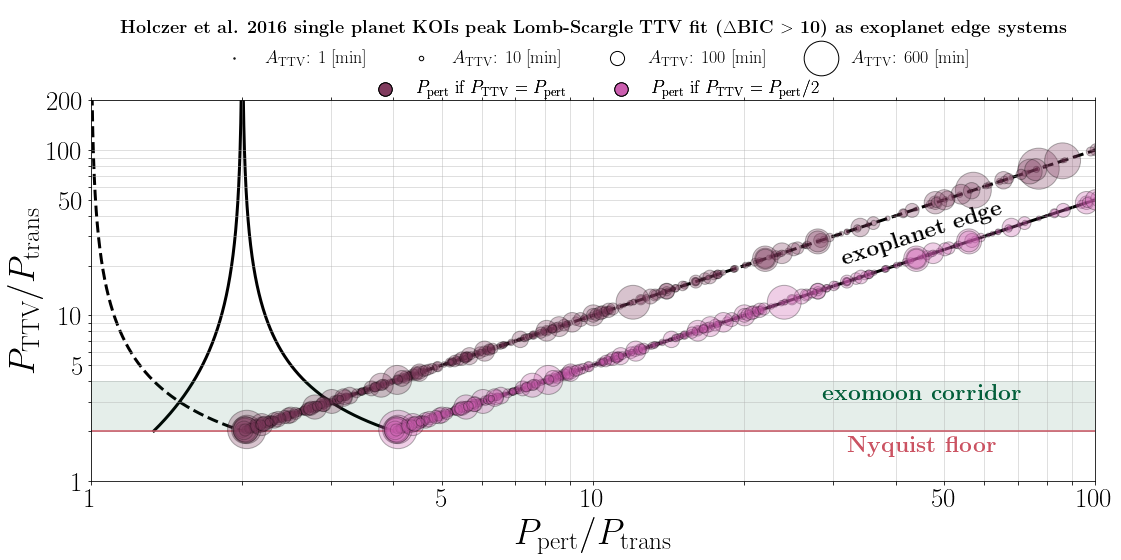

In [110]:
# Create a single plot
fig, ax = plt.subplots(figsize=[18, 7])

    
    
#plot the 1:2 super period
p2p1_analytic = np.arange(4/3, 4, .001)
j_analytic = 1
k_analytic = 2
pttv_analytic = super_period_norm(p2p1_analytic, j_analytic, k_analytic)


line2 = ax.plot(p2p1_analytic, pttv_analytic, color = 'k', lw = 3, ls='-', 
                label = str(j_analytic) + ':' + str(k_analytic) + ' super period', zorder=-1000000)   

# plot aliased 1:2 periods
count = 0
for alias_range in [[4, 100]]:
    p2p1_alias_range_analytic = np.arange(alias_range[0], alias_range[1], .0001)
    j_analytic = 1
    k_analytic = 2
    m = -1
    pttv_alias_range_analytic = alias_period( super_period_norm(p2p1_alias_range_analytic, j_analytic, k_analytic), m )
    
    ax.plot(p2p1_alias_range_analytic, pttv_alias_range_analytic, color='k', lw=3, ls='-',
            label = 'aliased ' + str(j_analytic) + ' : ' + str(k_analytic) + ', m = ' + str(m), zorder=-1000000)
    
    count += 1
    
#plot the synodic period
p2p1_analytic = np.arange(2/3, 2, .001)
j_analytic = 1
k_analytic = 1
pttv_analytic = super_period_norm(p2p1_analytic, j_analytic, k_analytic)


line1 = ax.plot(p2p1_analytic, pttv_analytic, color = 'k', lw = 3,
                label = 'synodic period', ls='--', zorder=-1000000)


# plot aliased synodic period
count = 0
for alias_range in [[2, 100]]:
    p2p1_alias_range_analytic = np.arange(alias_range[0], alias_range[1], .0001)
    j_analytic = 1
    k_analytic = 2
    m = -1
    pttv_alias_range_analytic = alias_period( chopping_period(1, p2p1_alias_range_analytic), m )
    
    ax.plot(p2p1_alias_range_analytic, pttv_alias_range_analytic, color='k', lw=3,
            label = 'aliased chopping period, m = ' + str(m), ls='--', zorder=-1000000)
    
    count += 1

    
# plot Nyquist floor
ax.axhline(2, 0, 1, color='#cb5362')
ax.text(45, 1.5, r'\textbf{Nyquist floor}', fontsize=23, ha='center', color='#cb5362')

# plot the exomoon corridor
ax.axhspan(2, 4, 0, 1, color='#025f3a', alpha=.1)
ax.text(45, 3.1, r'\textbf{exomoon corridor}', color= '#025f3a', fontsize=23, ha='center')

# add exoplanet edges label with a rotation angle
#ax.text(45, 54, r'\textbf{exoplanet}', fontsize=23, rotation=25, color='k', ha='center', va='center')
ax.text(45, 31, r'\textbf{exoplanet edge}', fontsize=23, rotation=18, color='k', ha='center', va='center')
#ax.text(9, 11, r'P$_\mathrm{TTV}$ = P$_\mathrm{pert}$', fontsize=23, rotation=25, color='k', ha='center', va='center')
#ax.text(9, 5.5, r'P$_\mathrm{TTV}$ = P$_\mathrm{pert}$/2', fontsize=23, rotation=25, color='k', ha='center', va='center')


# Set plot properties
ax.set_yscale("log", base=10)
ax.set_xscale("log", base=10)
ax.set_xlim(1, 100)
ax.set_ylim(1, 200)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_xticklabels([1, '', '', '', 5, '', '', '', '',
                    10, '', '', '', 50, '', '', '', '', 100])
ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200])
ax.set_yticklabels([1, '', '', '', 5, '', '', '', '',
                    10, '', '', '', 50, '', '', '', '', 100, 200])
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', bottom=True, top=True)

ax.set_xlabel(r'$P_\mathrm{pert}/P_\mathrm{trans}$', fontsize=36)
ax.set_ylabel(r'$P_\mathrm{TTV}/P_\mathrm{trans}$', fontsize=36)
ax.grid(True, alpha=0.5)




# Scatter plot with color based on 'amplitude' values
ax.scatter(holczer_singles['P_ttv [cycles]'],
           holczer_singles['P_ttv [cycles]'], alpha=0.3,
           s=holczer_singles['amplitude_ttv [min]']*2,  # Scale marker size based on 'amplitude' values
           color='#803b5e', edgecolors='black', zorder=1000)


# Scatter plot with color based on 'amplitude' values
ax.scatter(holczer_singles['P_ttv [cycles]']*2,
           holczer_singles['P_ttv [cycles]'], alpha=0.3,
           s=holczer_singles['amplitude_ttv [min]']*2,  # Scale marker size based on 'amplitude' values
           color='#cb5eaf', edgecolors='black', zorder=1000)



# Custom legend for marker sizes corresponding to specific amplitude values
legend_sizes = np.array([1, 10, 100, 600])
legend_labels = [fr'$A_\mathrm{{TTV}}$: {size} [min]' for size in legend_sizes]
legend_markers = [plt.scatter([], [], s=size, label=label, color='white', edgecolors='black') for size, label in zip(legend_sizes*2, legend_labels)]


# Custom legend entries for the scatter plot colors
color_markers = [
    plt.scatter([], [], color='#803b5e', edgecolors='black', label=fr'$P_\mathrm{{pert}}$ if $P_\mathrm{{TTV}}$ = $P_\mathrm{{pert}}$', s=180),
    plt.scatter([], [], color='#cb5eaf', edgecolors='black', label=fr'$P_\mathrm{{pert}}$ if $P_\mathrm{{TTV}}$ = $P_\mathrm{{pert}}/2$', s=180)
]



# Adjust the legend entries to split into two rows: top for size, bottom for color
# This creates two legends, one above the other
legend_size = ax.legend(handles=legend_markers, loc='upper center', fontsize=18, ncol=4, title_fontsize=18,
                        title=r"\textbf{Holczer et al. 2016 single planet KOIs peak Lomb-Scargle TTV fit ($\Delta$BIC $>$ 10) as exoplanet edge systems}",
                        bbox_to_anchor=(0.5, 1.27), frameon=False, borderpad=.7, handletextpad=.7, labelspacing=.7)

legend_color = ax.legend(handles=color_markers, loc='upper center', fontsize=18, ncol=3,
                         bbox_to_anchor=(0.5, 1.11), frameon=False, borderpad=.7, handletextpad=.7, labelspacing=.7)

# Add legends to the plot
ax.add_artist(legend_size)
ax.add_artist(legend_color)


# Optionally save the figure
plt.savefig('./figures/exoplanet_edge_holczer_singles_ttvs.pdf', bbox_inches='tight')

# Show the plot
plt.show()

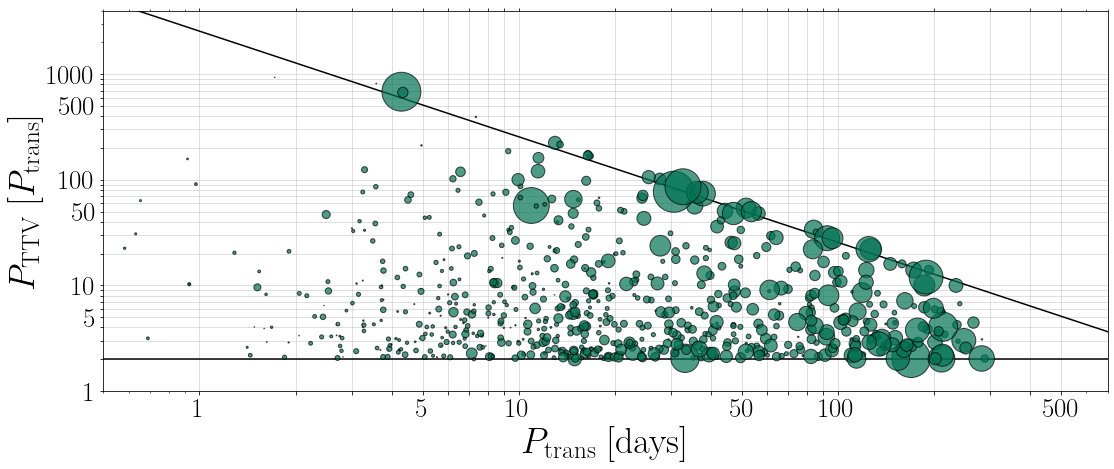

In [111]:
fig, ax = plt.subplots(figsize=[18, 7])

ax.scatter(holczer_singles['P_lin [days]'], holczer_singles['P_ttv [cycles]'],
           s=holczer_singles['amplitude_ttv [min]']*2,  # Scale marker size based on 'amplitude' values
           color='#007353', edgecolors='black', zorder=1000, alpha=.7)



# Generate x values
x = np.linspace(.6, 700, 1000)

# maximum recoverable period = 2*obs_baseline = 2*3.5years*365days/yr
y = (2*3.5*365)/x 

ax.plot(x, y, label='$y = -x - 1000$', color='k')
ax.axhline(2, 0, 1, color='k')


ax.set_xlim(0.5, 700)
ax.set_ylim(1, 4000)
ax.set_yscale("log", base=10)
ax.set_xscale("log", base=10)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90, 
               100, 200, 300, 400, 500])
ax.set_xticklabels([1, '', '', '', 5, '', '', '', '',
                    10, '', '', '', 50, '', '', '', '', 
                    100, '', '', '', 500])
ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90, 
               100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
ax.set_yticklabels([1, '', '', '', 5, '', '', '', '',
                    10, '', '', '', 50, '', '', '', '', 
                    100, '', '', '', 500, '', '', '', '', 1000])


ax.set_xlabel(r'$P_\mathrm{trans}$ [days]', fontsize=36)
ax.set_ylabel(r'$P_\mathrm{TTV}$ [$P_\mathrm{trans}$]', fontsize=36)
ax.grid(True, alpha=0.5)



ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', bottom=True, top=True)

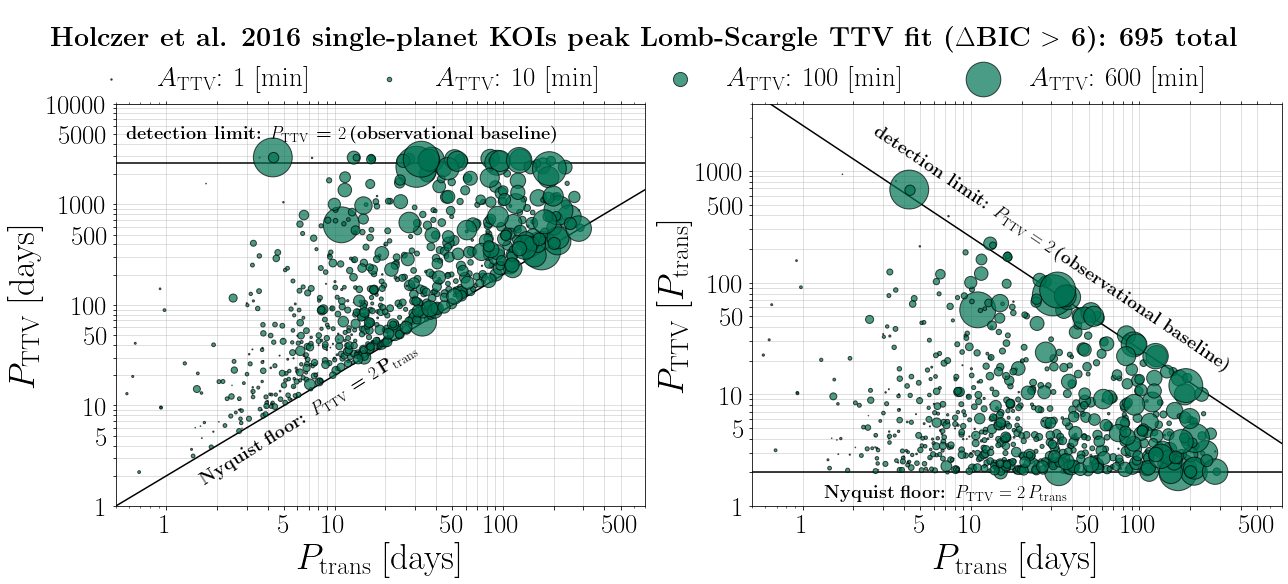

In [112]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=[18, 7])

# First subplot
ax = axs[0]
ax.scatter(holczer_singles['P_lin [days]'], holczer_singles['P_ttv [days]'],
           s=holczer_singles['amplitude_ttv [min]']*2,  # Scale marker size based on 'amplitude' values
           color='#007353', edgecolors='black', zorder=1000, alpha=0.7)

x = np.linspace(-1500, 1500, 500)
y = 2 * x
ax.plot(x, y, label='$y = -x - 1000$', color='k')
ax.axhline((2 * 3.5 * 365), 0, 1, color='k')


ax.text(7, 8, r"\textbf{Nyquist floor: $P_\mathrm{TTV}$ = $2\,$P$_\mathrm{trans}$}", fontsize=18, rotation=32, color='k', ha='center', va='center')
ax.text(11, 5000, r"\textbf{detection limit: $P_\mathrm{TTV}$ = $2\,$(observational baseline)}", fontsize=18, rotation=0, color='k', ha='center', va='center')




ax.set_xlim(0.5, 700)
ax.set_ylim(1, 10000)
ax.set_yscale("log", base=10)
ax.set_xscale("log", base=10)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90, 
               100, 200, 300, 400, 500])
ax.set_xticklabels([1, '', '', '', 5, '', '', '', '',
                    10, '', '', '', 50, '', '', '', '', 
                    100, '', '', '', 500])
ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90, 
               100, 200, 300, 400, 500, 600, 700, 800, 900, 
               1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
ax.set_yticklabels([1, '', '', '', 5, '', '', '', '',
                    10, '', '', '', 50, '', '', '', '', 
                    100, '', '', '', 500, '', '', '', '',
                    1000, '', '', '', 5000, '', '', '', '', 10000])

ax.set_xlabel(r'$P_\mathrm{trans}$ [days]', fontsize=36)
ax.set_ylabel(r'$P_\mathrm{TTV}$ [days]', fontsize=36)
ax.grid(True, alpha=0.5)

ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', bottom=True, top=True)

# Second subplot
ax = axs[1]
ax.scatter(holczer_singles['P_lin [days]'], holczer_singles['P_ttv [cycles]'],
           s=holczer_singles['amplitude_ttv [min]']*2,  # Scale marker size based on 'amplitude' values
           color='#007353', edgecolors='black', zorder=1000, alpha=.7)

x = np.linspace(.6, 700, 1000)
y = (2 * 3.5 * 365) / x
ax.plot(x, y, label='$y = -x - 1000$', color='k')
ax.axhline(2, 0, 1, color='k')




ax.text(7, 1.3, r"\textbf{Nyquist floor: $P_\mathrm{TTV} = 2\,P_\mathrm{trans}$}", fontsize=18, rotation=0, color='k', ha='center', va='center')
ax.text(30, 200, r"\textbf{detection limit: $P_\mathrm{TTV} = 2\,$(observational baseline)}", fontsize=18, rotation=-34, color='k', ha='center', va='center')




ax.set_xlim(0.5, 700)
ax.set_ylim(1, 4000)
ax.set_yscale("log", base=10)
ax.set_xscale("log", base=10)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90, 
               100, 200, 300, 400, 500])
ax.set_xticklabels([1, '', '', '', 5, '', '', '', '',
                    10, '', '', '', 50, '', '', '', '', 
                    100, '', '', '', 500])
ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90, 
               100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
ax.set_yticklabels([1, '', '', '', 5, '', '', '', '',
                    10, '', '', '', 50, '', '', '', '', 
                    100, '', '', '', 500, '', '', '', '', 1000])

ax.set_xlabel(r'$P_\mathrm{trans}$ [days]', fontsize=36)
ax.set_ylabel(r'$P_\mathrm{TTV}$ [$P_\mathrm{trans}$]', fontsize=36)
ax.grid(True, alpha=0.5)

ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', bottom=True, top=True)


# Calculate the number of rows in the DataFrame
num_rows = len(holczer_singles)

# Create the title string with the number of rows included
legend_title = fr"\textbf{{Holczer et al. 2016 single-planet KOIs peak Lomb-Scargle TTV fit ($\Delta$BIC $>$ 6): {num_rows} total}}" 

# Create the custom legend markers
legend_sizes = np.array([1, 10, 100, 600])
legend_labels = [fr'$A_\mathrm{{TTV}}$: {size} [min]' for size in legend_sizes]
legend_markers = [plt.scatter([], [], s=size, label=label, color='#007353', edgecolors='black', alpha=0.7) 
                  for size, label in zip(legend_sizes * 2, legend_labels)]

# Create the legend and apply it to the entire figure
legend_size = fig.legend(handles=legend_markers, loc='upper center', fontsize=27, ncol=4, title_fontsize=27,
                         title=legend_title, bbox_to_anchor=(0.5, 1.18), frameon=False, 
                         borderpad=.7, handletextpad=.7, labelspacing=.5)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])


# Adjust layout
plt.tight_layout()

# Optionally save the figure
plt.savefig('./figures/exoplanet_edge_holczer_singles_ttvs.pdf', bbox_inches='tight')

# Show the combined figure with subplots
plt.show()

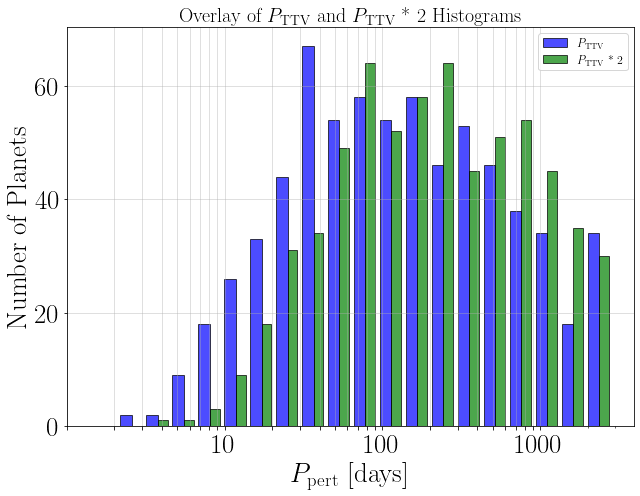

In [113]:

# Define the range for the log10 bins
min_val = holczer_singles['P_ttv [days]'].min()
max_val = holczer_singles['P_ttv [days]'].max()

# Create logarithmically spaced bins
bins = np.logspace(np.log10(min_val), np.log10(max_val), 20)

fig, ax = plt.subplots(figsize=(9, 7))

# Calculate the bin widths for log-spaced bins
bin_widths = np.diff(bins)

# Plot first histogram for 'P_ttv [days]', adjusting the position of the bars
ax.bar(bins[:-1], np.histogram(holczer_singles['P_ttv [days]'], bins=bins)[0], 
       width=bin_widths * 0.4, align='edge', color='blue', alpha=0.7, edgecolor='black', label=r'$P_\mathrm{TTV}$')

# Plot second histogram for 'P_ttv [days] * 2', shifting to the right of the first set
ax.bar(bins[:-1] + bin_widths * 0.4, np.histogram(holczer_singles['P_ttv [days]'] * 2, bins=bins)[0], 
       width=bin_widths * 0.4, align='edge', color='green', alpha=0.7, edgecolor='black', label=r'$P_\mathrm{TTV}$ * 2')



# Set titles and labels
ax.set_title(r'Overlay of $P_\mathrm{TTV}$ and $P_\mathrm{TTV}$ * 2 Histograms', fontsize=20)
ax.set_xlabel(r'$P_\mathrm{pert}$ [days]', fontsize=27)
ax.set_ylabel('Number of Planets', fontsize=27)

# Add grid and legend
ax.grid(True, alpha=0.5)
ax.legend(fontsize=12)

# Set x-axis to log10
ax.set_xscale('log', base=10)

#change x-ticks
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90, 
               100, 200, 300, 400, 500, 600, 700, 800, 900,
               1000])
ax.set_xticklabels(['', '', '', '', '', '', '', '', '',
                    10, '', '', '', '', '', '', '', '', 
                    100, '', '', '', '', '', '', '', '',
                    1000])

# Show plot
plt.tight_layout()
plt.show()


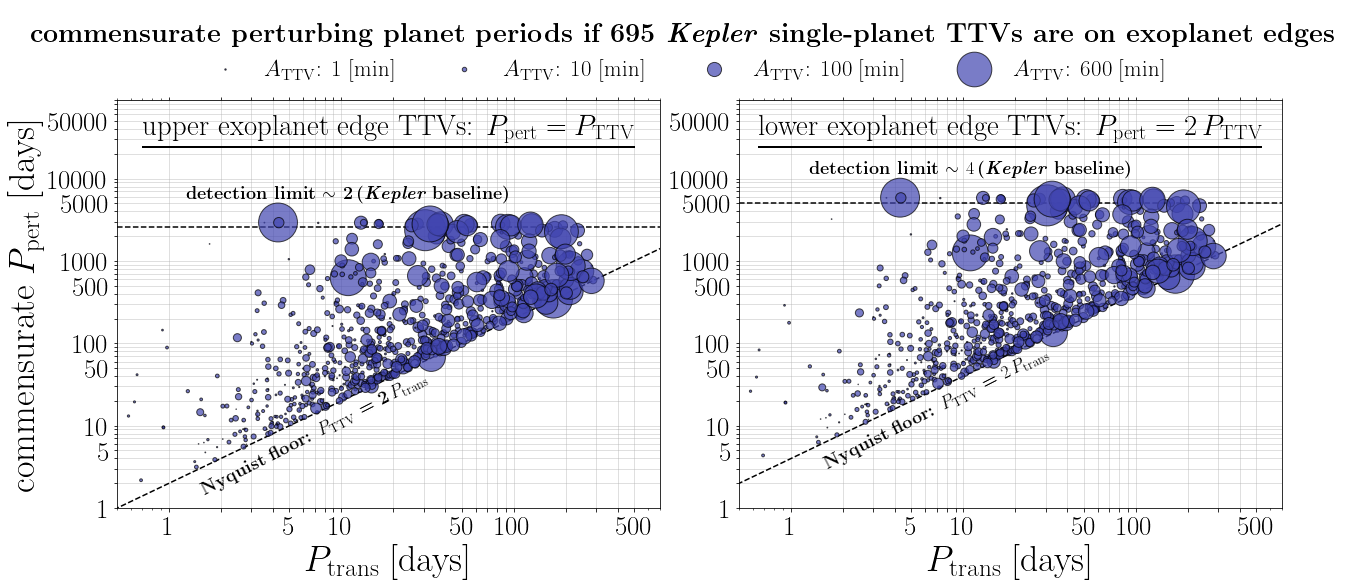

In [114]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=[18, 7])

# First subplot
ax = axs[0]
ax.scatter(holczer_singles['P_lin [days]'], holczer_singles['P_ttv [days]'],
           s=holczer_singles['amplitude_ttv [min]']*2,  # Scale marker size based on 'amplitude' values
           color='#4145b0', edgecolors='black', zorder=1000, alpha=0.7)

x = np.linspace(-1500, 1500, 500)
y = 2 * x
ax.plot(x, y, label='$y = -x - 1000$', color='k', ls='--')
ax.axhline((2 * 3.5 * 365), 0, 1, color='k', ls='--')


ax.text(7, 8, r"\textbf{Nyquist floor: $P_\mathrm{TTV}$ = 2$\,P_\mathrm{trans}$}", fontsize=18, rotation=27, color='k', ha='center', va='center')
ax.text(11, 6500, r"\textbf{detection limit $\sim$ 2$\,$(\textit{Kepler} baseline)}", fontsize=18, rotation=0, color='k', ha='center', va='center')




ax.set_xlim(0.5, 700)
ax.set_ylim(1, 10000)
ax.set_yscale("log", base=10)
ax.set_xscale("log", base=10)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90, 
               100, 200, 300, 400, 500])
ax.set_xticklabels([1, '', '', '', 5, '', '', '', '',
                    10, '', '', '', 50, '', '', '', '', 
                    100, '', '', '', 500])
ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90, 
               100, 200, 300, 400, 500, 600, 700, 800, 900, 
               1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 
               10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000])
ax.set_yticklabels([1, '', '', '', 5, '', '', '', '',
                    10, '', '', '', 50, '', '', '', '', 
                    100, '', '', '', 500, '', '', '', '', 
                    1000, '', '', '', 5000, '', '', '', '', 
                    10000, '', '', '', 50000, '', '', '', ''])


ax.set_xlabel(r'$P_\mathrm{trans}$ [days]', fontsize=36)
ax.set_ylabel(r'commensurate $P_\mathrm{pert}$ [days]', fontsize=36)
ax.set_title(r'\underline{upper exoplanet edge TTVs: $P_\mathrm{pert} = P_\mathrm{TTV}$}', fontsize=29, y=.9)
ax.grid(True, alpha=0.5)

ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', bottom=True, top=True)

# Second subplot
ax = axs[1]
ax.scatter(holczer_singles['P_lin [days]'], holczer_singles['P_ttv [days]']*2.,
           s=holczer_singles['amplitude_ttv [min]']*2,  # Scale marker size based on 'amplitude' values
           color='#4145b0', edgecolors='black', zorder=1000, alpha=0.7)

x = np.linspace(-1500, 1500, 500)
y = 2 * x
ax.plot(x, 2*y, label='$y = -x - 1000$', color='k', ls='--')
ax.axhline(2*(2 * 3.5 * 365), 0, 1, color='k', ls='--')


ax.text(7, 16, r"\textbf{Nyquist floor: $P_\mathrm{TTV}$ = $2\,P_\mathrm{trans}$}", fontsize=18, rotation=27, color='k', ha='center', va='center')
ax.text(11, 13000, r"\textbf{detection limit $\sim$ $4\,$(\textit{Kepler} baseline)}", fontsize=18, rotation=0, color='k', ha='center', va='center')



ax.set_xlim(0.5, 700)
ax.set_ylim(1, 4000)
ax.set_yscale("log", base=10)
ax.set_xscale("log", base=10)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90, 
               100, 200, 300, 400, 500])
ax.set_xticklabels([1, '', '', '', 5, '', '', '', '',
                    10, '', '', '', 50, '', '', '', '', 
                    100, '', '', '', 500])
ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90, 
               100, 200, 300, 400, 500, 600, 700, 800, 900, 
               1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 
               10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000])
ax.set_yticklabels([1, '', '', '', 5, '', '', '', '',
                    10, '', '', '', 50, '', '', '', '', 
                    100, '', '', '', 500, '', '', '', '', 
                    1000, '', '', '', 5000, '', '', '', '', 
                    10000, '', '', '', 50000, '', '', '', ''])

ax.set_xlabel(r'$P_\mathrm{trans}$ [days]', fontsize=36)
ax.set_title(r'\underline{lower exoplanet edge TTVs: $P_\mathrm{pert} = 2\,P_\mathrm{TTV}$}', fontsize=29, y=.9)
ax.grid(True, alpha=0.5)

ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', bottom=True, top=True)


# Calculate the number of rows in the DataFrame
num_rows = len(holczer_singles)

# Create the title string with the number of rows included
legend_title = fr"\textbf{{commensurate perturbing planet periods if {num_rows} \textit{{Kepler}} single-planet TTVs are on exoplanet edges}}" 

# Create the custom legend markers
legend_sizes = np.array([1, 10, 100, 600])
legend_labels = [fr'$A_\mathrm{{TTV}}$: {size} [min]' for size in legend_sizes]
legend_markers = [plt.scatter([], [], s=size, label=label, color='#4145b0', edgecolors='black', alpha=0.7) 
                  for size, label in zip(legend_sizes * 2, legend_labels)]

# Create the legend and apply it to the entire figure
legend_size = fig.legend(handles=legend_markers, loc='upper center', fontsize=23, ncol=4, title_fontsize=27,
                         title=legend_title, bbox_to_anchor=(0.53, 1.18), frameon=False, 
                         borderpad=.7, handletextpad=.7, labelspacing=.5)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])


# Adjust layout
plt.tight_layout()

# Optionally save the figure
plt.savefig('./figures/exoplanet_edge_holczer_singles_ttvs.pdf', bbox_inches='tight')

# Show the combined figure with subplots
plt.show()